# AML Cell-Cell Interaction Modeling with DIISCO

In [1]:
cd ..

/Users/shouvikmani/Desktop/DIISCO/DIISCO/diisco


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from matplotlib.colors import LogNorm
import seaborn as sns
#import tensorflow as tf
#from Scalable_GPRN.model.SGPRN import SGPRN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
# reload edited modules always
%load_ext autoreload
%autoreload 2
from diisco import DIISCO
import diisco.names as names

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
days_to_dli = pd.read_csv('../../data/AML/AML_days_to_DLI.csv')
days_to_dli.head()

,sample,days_to_DLI
0,MS2_,-91
1,MS4_,-16
2,MS3_,54
3,MS1_,1692
4,LB3_,-115


In [5]:
cells_df = pd.read_csv('../../data/AML/diisco_runs/run_1/diisco_all_immune_cells.csv', index_col='Unnamed: 0')
# Remove doublet clusters
cells_df = cells_df[~cells_df['cluster_number'].isin([32, 34, 35, 43, 53])]
cells_df = cells_df[cells_df['dataset'].str.contains('aml')]
cells_df = pd.merge(cells_df, days_to_dli, left_on='sample', right_on='sample')
cells_df = cells_df[cells_df['days_to_DLI'] <= 1000]
cells_df

,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
0,11.945880,-5.867986,EL1_,8,aml1,EL,PRE,RESPONDER,x,AML,Mid erythroid,0.0,donor,AML_R_PRE,BM,MC5,-46
1,-2.083548,7.255095,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
2,-2.955473,7.885801,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
3,-2.837099,7.800364,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
4,-2.916190,7.826178,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34814,0.216889,-2.060157,GD3_,1,aml1,GD,PRE,NONRESPONDER,x,AML,CD16+ NK cells,0.0,tumor,AML_NR_PRE,BM,1,-179
34815,-1.474262,1.229219,GD3_,0,aml1,GD,PRE,NONRESPONDER,x,AML,Tem/Temra cytotoxic T cells,0.0,tumor,AML_NR_PRE,BM,0,-179
34816,-1.091123,-4.655160,GD3_,1,aml1,GD,PRE,NONRESPONDER,x,AML,CD16+ NK cells,0.0,tumor,AML_NR_PRE,BM,1,-179
34817,11.836526,12.776303,GD3_,23,aml1,GD,PRE,NONRESPONDER,x,AML,Large pre-B cells,0.0,tumor,AML_NR_PRE,BM,23,-179


## Responders model

In [6]:
cells_df_responders = cells_df[cells_df['response'] == 'RESPONDER']
cells_df_responders

,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
0,11.945880,-5.867986,EL1_,8,aml1,EL,PRE,RESPONDER,x,AML,Mid erythroid,0.0,donor,AML_R_PRE,BM,MC5,-46
1,-2.083548,7.255095,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
2,-2.955473,7.885801,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
3,-2.837099,7.800364,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
4,-2.916190,7.826178,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34583,7.000071,3.118854,MS4_,39,aml1,MS,PRE,RESPONDER,x,AML,Classical monocytes,0.0,donor,AML_R_PRE,BM,MC7,-16
34584,10.042539,5.447767,MS4_,9,aml1,MS,PRE,RESPONDER,x,AML,Promyelocytes,0.0,donor,AML_R_PRE,BM,MC2,-16
34585,5.158579,4.008451,MS4_,4,aml1,MS,PRE,RESPONDER,x,AML,Classical monocytes,0.0,donor,AML_R_PRE,BM,MC3,-16
34586,6.837269,2.754053,MS4_,39,aml1,MS,PRE,RESPONDER,x,AML,Classical monocytes,0.0,donor,AML_R_PRE,BM,MC7,-16


In [7]:
clusters_of_interest = {
    '0': 'T cell',
    '1': 'NK cell',
    '13': 'NK cell',
    '2': 'T cell',
    '20': 'B cell',
    '21': 'T cell',
    '26': 'T cell',
    '3': 'B cell',
    '40': 'T cell',
    '5': 'T cell',
    'MC1': 'Myeloid',
    'MC2': 'Myeloid',
    'MC3': 'Myeloid',
    'MC4': 'Myeloid',
    'MC7': 'Myeloid'
}

colors = {
    'T cell': 'tab:blue',
    'B cell': 'tab:pink',
    'Myeloid': 'tab:red',
    'AML': 'tab:gray',
    'HSC': 'goldenrod',
    'NK cell': 'tab:purple'
}

In [8]:
sample_cluster_proportions = []

all_clusters = sorted(cells_df_responders['diisco_cluster'].unique())
for sample, sample_df in cells_df_responders.groupby('sample'):
    cluster_proportions = sample_df['diisco_cluster'].value_counts(normalize=True)
    cluster_proportions_dict = {cluster: (cluster_proportions[cluster] 
                                          if cluster in cluster_proportions
                                          else 0)
                                for cluster in all_clusters}
    sample_cluster_proportions.append({
        'sample': sample,
        'days_to_DLI': sample_df.iloc[0]['days_to_DLI'],
        **cluster_proportions_dict
    })
    
sample_cluster_proportions_all_df = pd.DataFrame(sample_cluster_proportions)
sample_cluster_proportions_all_df = sample_cluster_proportions_all_df.sort_values('days_to_DLI')
sample_cluster_proportions_all_df

,sample,days_to_DLI,0,1,13,14,18,2,20,21,...,48,5,MC1,MC2,MC3,MC4,MC5,MC6,MC7,MC8
4,KC1_,-195,0.067352,0.019406,0.035388,0.069635,0.000000,0.004566,0.027397,0.001142,...,0.000000,0.007991,0.092466,0.125571,0.213470,0.117580,0.014840,0.000000,0.007991,0.000000
9,LB3_,-115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,EL3_,-100,0.033259,0.076497,0.003326,0.000000,0.000000,0.057650,0.024390,0.021064,...,0.000000,0.003326,0.646341,0.018847,0.003326,0.004435,0.003326,0.001109,0.009978,0.000000
11,MS2_,-91,0.078616,0.161950,0.034591,0.006289,0.000000,0.077044,0.009434,0.006289,...,0.000000,0.018868,0.006289,0.018868,0.246855,0.014151,0.000000,0.000000,0.023585,0.001572
5,KC2_,-79,0.015396,0.020528,0.018328,0.011730,0.000000,0.005865,0.006598,0.000733,...,0.000000,0.002933,0.013196,0.149560,0.538856,0.031525,0.008065,0.000733,0.016129,0.000000
0,EL1_,-46,0.023729,0.105085,0.006780,0.000000,0.003390,0.576271,0.000000,0.037288,...,0.003390,0.010169,0.010169,0.006780,0.023729,0.054237,0.040678,0.000000,0.006780,0.000000
13,MS4_,-16,0.041611,0.095302,0.017450,0.000000,0.000000,0.018792,0.000000,0.006711,...,0.009396,0.006711,0.010738,0.132886,0.409396,0.018792,0.002685,0.001342,0.159732,0.000000
12,MS3_,54,0.160669,0.102929,0.011715,0.000000,0.000000,0.035146,0.008368,0.088703,...,0.000000,0.013389,0.019247,0.023431,0.097071,0.174059,0.001674,0.000000,0.015063,0.000000
6,KC4_,103,0.441999,0.223051,0.008952,0.000000,0.000000,0.015293,0.011190,0.014174,...,0.000373,0.024991,0.001119,0.002611,0.007087,0.011190,0.002238,0.000373,0.003357,0.000373
7,LB1_,258,0.430159,0.193474,0.025044,0.004233,0.000000,0.029277,0.012698,0.004938,...,0.000000,0.031041,0.002293,0.015344,0.067725,0.005291,0.002116,0.000705,0.003704,0.000353


In [9]:
sample_cluster_proportions_df = sample_cluster_proportions_all_df[['sample', 'days_to_DLI'] 
                                                                  + list(clusters_of_interest.keys())]
sample_cluster_proportions_df

,sample,days_to_DLI,0,1,13,2,20,21,26,3,40,5,MC1,MC2,MC3,MC4,MC7
4,KC1_,-195,0.067352,0.019406,0.035388,0.004566,0.027397,0.001142,0.000000,0.126712,0.003425,0.007991,0.092466,0.125571,0.213470,0.117580,0.007991
9,LB3_,-115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,EL3_,-100,0.033259,0.076497,0.003326,0.057650,0.024390,0.021064,0.000000,0.080931,0.002217,0.003326,0.646341,0.018847,0.003326,0.004435,0.009978
11,MS2_,-91,0.078616,0.161950,0.034591,0.077044,0.009434,0.006289,0.014151,0.187107,0.029874,0.018868,0.006289,0.018868,0.246855,0.014151,0.023585
5,KC2_,-79,0.015396,0.020528,0.018328,0.005865,0.006598,0.000733,0.000733,0.120235,0.016129,0.002933,0.013196,0.149560,0.538856,0.031525,0.016129
0,EL1_,-46,0.023729,0.105085,0.006780,0.576271,0.000000,0.037288,0.030508,0.000000,0.023729,0.010169,0.010169,0.006780,0.023729,0.054237,0.006780
13,MS4_,-16,0.041611,0.095302,0.017450,0.018792,0.000000,0.006711,0.045638,0.000000,0.004027,0.006711,0.010738,0.132886,0.409396,0.018792,0.159732
12,MS3_,54,0.160669,0.102929,0.011715,0.035146,0.008368,0.088703,0.028452,0.114644,0.093724,0.013389,0.019247,0.023431,0.097071,0.174059,0.015063
6,KC4_,103,0.441999,0.223051,0.008952,0.015293,0.011190,0.014174,0.089892,0.063782,0.066020,0.024991,0.001119,0.002611,0.007087,0.011190,0.003357
7,LB1_,258,0.430159,0.193474,0.025044,0.029277,0.012698,0.004938,0.004056,0.120459,0.028219,0.031041,0.002293,0.015344,0.067725,0.005291,0.003704


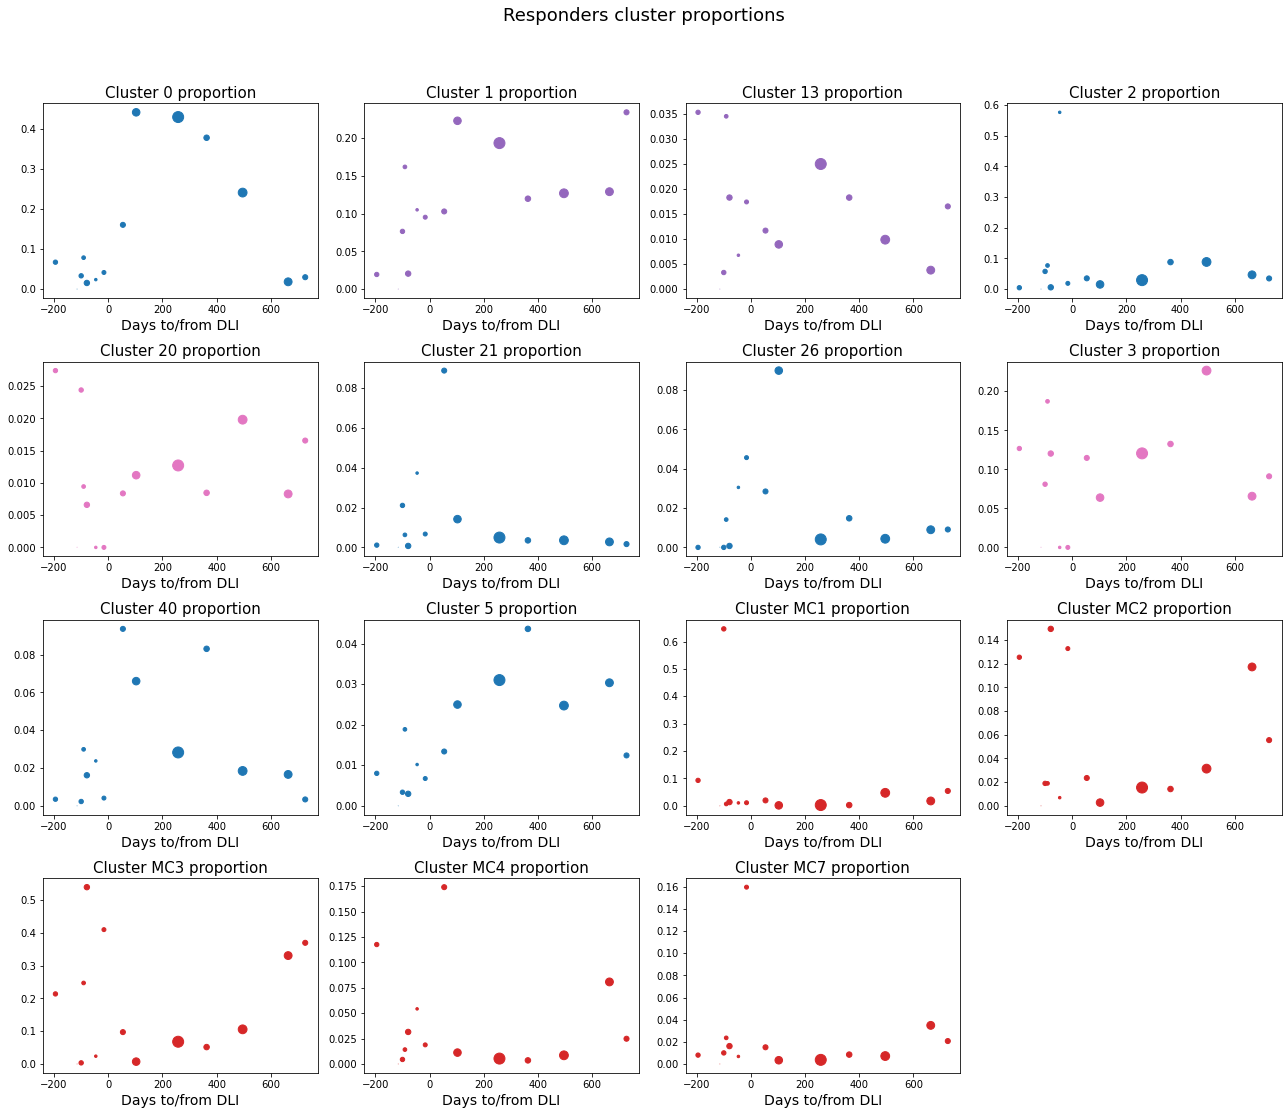

In [10]:
cells_per_sample = cells_df_responders['sample'].value_counts(normalize=True)[sample_cluster_proportions_df['sample']]

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    color = colors[list(clusters_of_interest.values())[i]]
    plt.subplot(5, 4, i+1)
    plt.scatter(sample_cluster_proportions_df['days_to_DLI'], 
                sample_cluster_proportions_df[cluster], 
                s=cells_per_sample*500, 
                color=color)
    plt.title(f'Cluster {cluster} proportion', fontsize=15)
    plt.xlabel('Days to/from DLI', fontsize=14)
plt.suptitle(f'Responders cluster proportions', y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig('../../figures/AML/run_1/cell_type_proportions_R.eps', bbox_inches='tight')

In [11]:
cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
sample_cluster_proportions_df.loc[:, clusters_of_interest] /= cluster_std_devs
sample_cluster_proportions_df

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/858897236.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/858897236.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a 

,sample,days_to_DLI,0,1,13,2,20,21,26,3,40,5,MC1,MC2,MC3,MC4,MC7
4,KC1_,-195,-0.443891,-1.319843,1.860994,-0.493429,1.910308,-0.528596,-0.720397,0.471320,-0.787442,-0.659146,0.157322,1.361293,0.212358,1.521602,-0.362323
9,LB3_,-115,-0.855150,-1.588107,-1.370829,-0.524539,-1.269946,-0.576439,-0.720397,-1.409807,-0.898199,-1.280003,-0.389442,-0.926961,-0.997593,-0.761228,-0.559465
2,EL3_,-100,-0.652063,-0.530658,-1.067087,-0.131772,1.561256,0.306375,-0.720397,-0.208330,-0.826490,-1.021591,3.432469,-0.583515,-0.978742,-0.675130,-0.313303
11,MS2_,-91,-0.375107,0.650599,1.788214,0.000362,-0.174858,-0.312851,-0.151129,1.367916,0.067966,0.185956,-0.352252,-0.583134,0.401584,-0.486485,0.022396
5,KC2_,-79,-0.761140,-1.304341,0.303017,-0.484580,-0.504027,-0.545713,-0.690904,0.375154,-0.376569,-1.052156,-0.311409,1.798446,2.056647,-0.149167,-0.161547
0,EL1_,-46,-0.710258,-0.135471,-0.751676,3.401595,-1.269946,0.986323,0.506906,-1.409807,-0.130783,-0.489876,-0.329308,-0.803416,-0.863098,0.291796,-0.392205
13,MS4_,-16,-0.601069,-0.270703,0.222763,-0.396509,-1.269946,-0.295161,1.115524,-1.409807,-0.767967,-0.758555,-0.325945,1.494595,1.322865,-0.396380,3.381255
12,MS3_,54,0.125921,-0.165273,-0.300912,-0.285086,-0.298571,3.141138,0.424173,0.292163,2.132934,-0.239724,-0.275632,-0.499983,-0.447393,2.618143,-0.187853
6,KC4_,103,1.843763,1.495233,-0.553298,-0.420349,0.028964,0.017592,2.895795,-0.462919,1.236966,0.661667,-0.382825,-0.879382,-0.957424,-0.543975,-0.476646
7,LB1_,258,1.771463,1.086380,0.916324,-0.325075,0.204077,-0.369474,-0.557213,0.378478,0.014425,1.131718,-0.375884,-0.647352,-0.613728,-0.658502,-0.468091


In [12]:
X = sample_cluster_proportions_df['days_to_DLI'].values.reshape(-1, 1)
X

array([[-195],
       [-115],
       [-100],
       [ -91],
       [ -79],
       [ -46],
       [ -16],
       [  54],
       [ 103],
       [ 258],
       [ 363],
       [ 496],
       [ 664],
       [ 727]])

In [13]:
Y = sample_cluster_proportions_df[clusters_of_interest].values
Y[:5]

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/2580917083.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  Y = sample_cluster_proportions_df[clusters_of_interest].values


array([[-4.43891221e-01, -1.31984325e+00,  1.86099423e+00,
        -4.93429219e-01,  1.91030839e+00, -5.28595870e-01,
        -7.20396885e-01,  4.71319575e-01, -7.87442245e-01,
        -6.59146001e-01,  1.57321733e-01,  1.36129286e+00,
         2.12357732e-01,  1.52160169e+00, -3.62322994e-01],
       [-8.55150077e-01, -1.58810687e+00, -1.37082943e+00,
        -5.24538790e-01, -1.26994592e+00, -5.76438815e-01,
        -7.20396885e-01, -1.40980692e+00, -8.98199492e-01,
        -1.28000277e+00, -3.89441613e-01, -9.26961011e-01,
        -9.97593051e-01, -7.61227752e-01, -5.59464814e-01],
       [-6.52063100e-01, -5.30657657e-01, -1.06708747e+00,
        -1.31771836e-01,  1.56125609e+00,  3.06374911e-01,
        -7.20396885e-01, -2.08329950e-01, -8.26489700e-01,
        -1.02159105e+00,  3.43246875e+00, -5.83515369e-01,
        -9.78741594e-01, -6.75129606e-01, -3.13302935e-01],
       [-3.75106960e-01,  6.50599189e-01,  1.78821427e+00,
         3.61845944e-04, -1.74858353e-01, -3.12851267

Text(0.5, 1.02, 'Interaction prior variances for responders based on receptor-ligand expression')

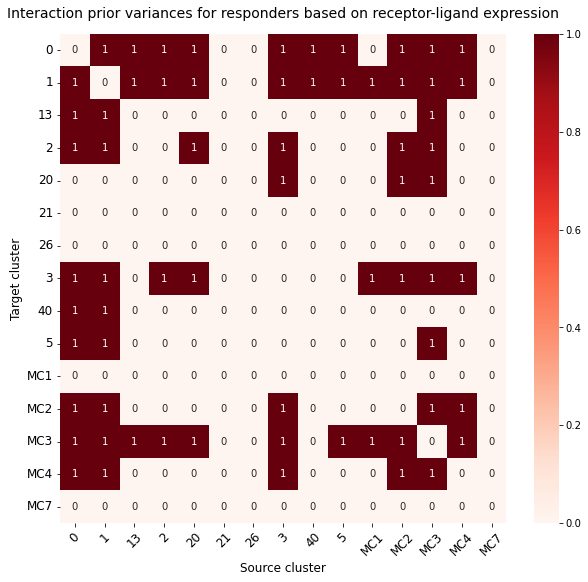

In [14]:
W_prior_variance = np.load('../../data/AML/responder_interaction_prior_run_1.npy')

plt.figure(figsize=(10, 9))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('Interaction prior variances for responders based on receptor-ligand expression', 
          fontsize=14, y=1.02)

In [15]:
timepoints = torch.tensor(X)
proportions = torch.tensor(Y)
prior_matrix = torch.tensor(W_prior_variance)
n_timepoints, n_cell_types = proportions.shape

print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([14, 1])
cell_types.shape: torch.Size([14, 15])


In [16]:
def unscale(proportions, cluster_index): 
    return np.clip((proportions * 
                    cluster_std_devs.values[cluster_index] + 
                    cluster_means.values[cluster_index]), 
                   0, 1)

In [17]:
# mean of all intervals
lengthscale = np.mean(np.abs(X - X.T))
lengthscale

319.3775510204082

In [18]:
hyper_init_vals = {
    names.LENGTHSCALE_F: 300,
    names.LENGTHSCALE_W: 300,
    names.SIGMA_F: 1,
    names.VARIANCE_F: 1,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 1,
    names.SIGMA_Y: 0.5,
}

In [20]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

Text(0.5, 0.95, 'Independent GP fits to set $f_i$ latent functions')

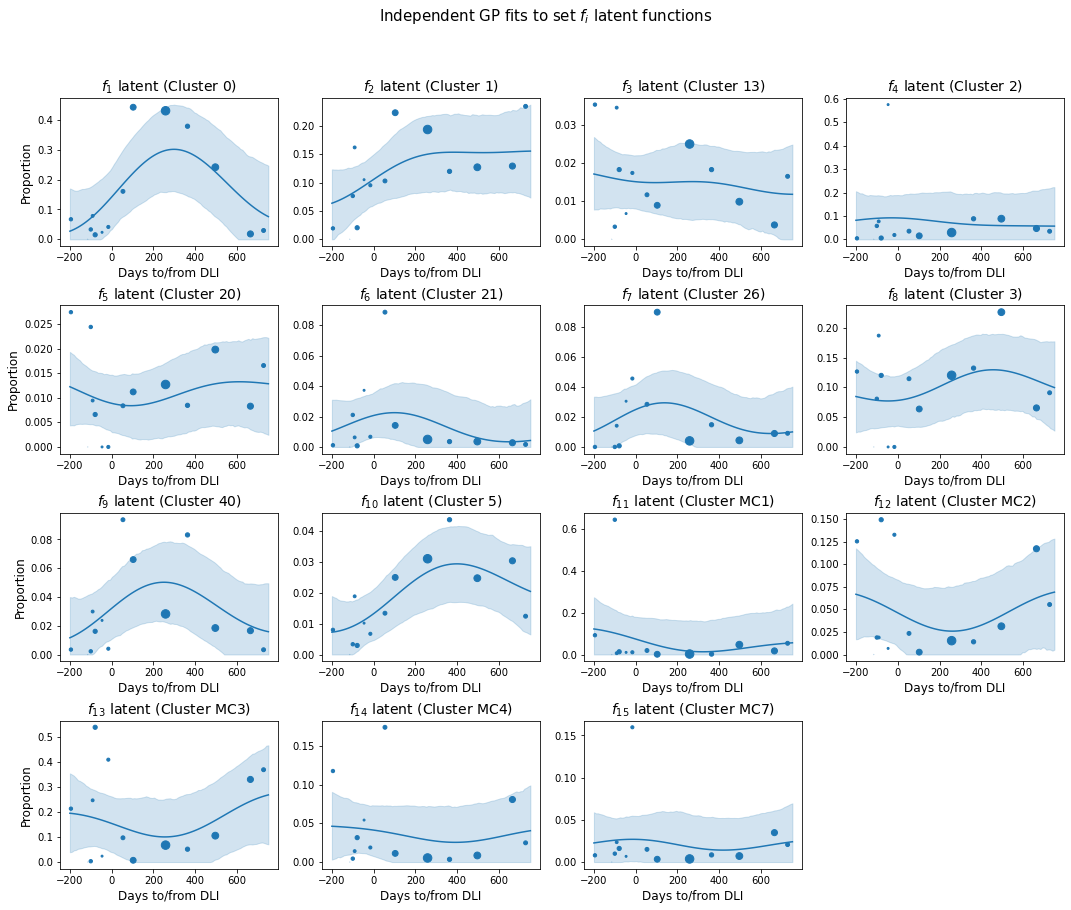

In [21]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
eval_timepoints = torch.linspace(-200, 750, 100).view(-1, 1)

n_samples = 1000
n_eval_timepoints = eval_timepoints.shape[0]
f_prior_np = model.sample_f_prior(eval_timepoints, n_samples=n_samples)

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    eval_timepoints_np = eval_timepoints.detach().numpy()
    f_prior_cell_type_np = f_prior_np[:, i, :].detach().numpy()
    mean = unscale(f_prior_cell_type_np.mean(axis=0), i)
    upper = unscale(np.percentile(f_prior_cell_type_np, 97.5, axis=0), i)
    lower = unscale(np.percentile(f_prior_cell_type_np, 2.5, axis=0), i)
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    color = 'tab:blue'
    plt.plot(eval_timepoints_np, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i].flatten().detach().numpy(), i), 
                c=color, s=cells_per_sample*300)
    plt.fill_between(eval_timepoints_np.flatten(), lower, upper, color=color, alpha=0.2)
    plt.title('$f_{%s}$ latent (Cluster %s)' % (i+1, cluster), fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
plt.subplots_adjust(hspace=0.4)
plt.suptitle('Independent GP fits to set $f_i$ latent functions', fontsize=15, y=0.95)

In [22]:
model.fit(timepoints, 
          proportions, 
          n_iter=300000, 
          lr=0.00001, 
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 508931.5932
[iteration 0101] loss: 313431.5769
[iteration 0201] loss: 291248.1368
[iteration 0301] loss: 276699.6650
[iteration 0401] loss: 265902.1963
[iteration 0501] loss: 260997.8021
[iteration 0601] loss: 252365.8086
[iteration 0701] loss: 248243.7785
[iteration 0801] loss: 242502.6872
[iteration 0901] loss: 238723.9577
[iteration 1001] loss: 235261.0413
[iteration 1101] loss: 231857.9172
[iteration 1201] loss: 228074.6080
[iteration 1301] loss: 225560.3029
[iteration 1401] loss: 222787.6412
[iteration 1501] loss: 219718.1782
[iteration 1601] loss: 217578.3649
[iteration 1701] loss: 214502.5374
[iteration 1801] loss: 211869.0605
[iteration 1901] loss: 210467.0869
[iteration 2001] loss: 207609.9793
[iteration 2101] loss: 206662.4985
[iteration 2201] loss: 204490.3988
[iteration 2301] loss: 201843.1269
[iteration 2401] loss: 199886.0902
[iteration 2501] loss: 199473.6645
[iteration 2601] loss: 196401.2300
[iteration 2701] loss: 196116.7290
[iteration 2801] los

[iteration 23101] loss: 97256.8321
[iteration 23201] loss: 97022.1361
[iteration 23301] loss: 97938.0477
[iteration 23401] loss: 97700.4529
[iteration 23501] loss: 97742.4812
[iteration 23601] loss: 97243.4264
[iteration 23701] loss: 98028.0547
[iteration 23801] loss: 97809.0658
[iteration 23901] loss: 97734.2632
[iteration 24001] loss: 97769.3644
[iteration 24101] loss: 97410.5968
[iteration 24201] loss: 95859.8460
[iteration 24301] loss: 96740.1294
[iteration 24401] loss: 97031.4312
[iteration 24501] loss: 97040.5488
[iteration 24601] loss: 97567.7242
[iteration 24701] loss: 97220.8511
[iteration 24801] loss: 98154.3573
[iteration 24901] loss: 96782.7081
[iteration 25001] loss: 96905.6864
[iteration 25101] loss: 96177.2912
[iteration 25201] loss: 96596.3655
[iteration 25301] loss: 96363.0960
[iteration 25401] loss: 96068.9389
[iteration 25501] loss: 96392.2091
[iteration 25601] loss: 95890.6878
[iteration 25701] loss: 95018.2791
[iteration 25801] loss: 96263.4800
[iteration 25901] lo

[iteration 46601] loss: 84690.6709
[iteration 46701] loss: 84265.7511
[iteration 46801] loss: 84035.8763
[iteration 46901] loss: 83952.8857
[iteration 47001] loss: 85181.5011
[iteration 47101] loss: 84058.7830
[iteration 47201] loss: 84470.2127
[iteration 47301] loss: 84395.6456
[iteration 47401] loss: 84437.2703
[iteration 47501] loss: 84256.1752
[iteration 47601] loss: 84330.1099
[iteration 47701] loss: 84129.7357
[iteration 47801] loss: 83954.3280
[iteration 47901] loss: 83570.4594
[iteration 48001] loss: 82979.4570
[iteration 48101] loss: 84077.9741
[iteration 48201] loss: 83442.3723
[iteration 48301] loss: 83685.7927
[iteration 48401] loss: 83765.2569
[iteration 48501] loss: 84387.9637
[iteration 48601] loss: 82934.9896
[iteration 48701] loss: 83886.7591
[iteration 48801] loss: 83987.4338
[iteration 48901] loss: 83792.8398
[iteration 49001] loss: 83743.2316
[iteration 49101] loss: 83207.2391
[iteration 49201] loss: 83505.9470
[iteration 49301] loss: 83891.0401
[iteration 49401] lo

[iteration 70101] loss: 78116.7367
[iteration 70201] loss: 78117.9671
[iteration 70301] loss: 78427.1404
[iteration 70401] loss: 78948.6211
[iteration 70501] loss: 78199.5757
[iteration 70601] loss: 78226.1142
[iteration 70701] loss: 78129.0595
[iteration 70801] loss: 78478.9344
[iteration 70901] loss: 77860.3418
[iteration 71001] loss: 77532.6460
[iteration 71101] loss: 78231.8250
[iteration 71201] loss: 77630.8753
[iteration 71301] loss: 77912.9200
[iteration 71401] loss: 78572.1870
[iteration 71501] loss: 78135.7167
[iteration 71601] loss: 78609.0719
[iteration 71701] loss: 77610.0125
[iteration 71801] loss: 77539.0038
[iteration 71901] loss: 78577.8829
[iteration 72001] loss: 78734.8076
[iteration 72101] loss: 78188.5354
[iteration 72201] loss: 78291.8207
[iteration 72301] loss: 78698.5936
[iteration 72401] loss: 77501.5142
[iteration 72501] loss: 78552.8481
[iteration 72601] loss: 77516.6011
[iteration 72701] loss: 77901.4418
[iteration 72801] loss: 78050.5160
[iteration 72901] lo

[iteration 93601] loss: 74297.6795
[iteration 93701] loss: 75477.9653
[iteration 93801] loss: 75645.2927
[iteration 93901] loss: 74798.1378
[iteration 94001] loss: 74884.8103
[iteration 94101] loss: 75523.0825
[iteration 94201] loss: 75225.4464
[iteration 94301] loss: 75296.9087
[iteration 94401] loss: 74435.5994
[iteration 94501] loss: 74617.1093
[iteration 94601] loss: 75017.0958
[iteration 94701] loss: 74639.2664
[iteration 94801] loss: 76028.2371
[iteration 94901] loss: 75523.4048
[iteration 95001] loss: 74993.0092
[iteration 95101] loss: 75109.2145
[iteration 95201] loss: 74881.0282
[iteration 95301] loss: 74924.5607
[iteration 95401] loss: 74558.3470
[iteration 95501] loss: 75122.9082
[iteration 95601] loss: 75272.5278
[iteration 95701] loss: 75035.6981
[iteration 95801] loss: 74340.0885
[iteration 95901] loss: 74060.6435
[iteration 96001] loss: 75031.6109
[iteration 96101] loss: 74936.2400
[iteration 96201] loss: 73748.8543
[iteration 96301] loss: 74151.7146
[iteration 96401] lo

[iteration 116601] loss: 72362.9552
[iteration 116701] loss: 72987.8458
[iteration 116801] loss: 73048.2342
[iteration 116901] loss: 72811.8813
[iteration 117001] loss: 73379.3858
[iteration 117101] loss: 72183.2994
[iteration 117201] loss: 72332.1917
[iteration 117301] loss: 72258.2275
[iteration 117401] loss: 72075.6360
[iteration 117501] loss: 72071.4766
[iteration 117601] loss: 72725.0046
[iteration 117701] loss: 72316.5820
[iteration 117801] loss: 72508.3451
[iteration 117901] loss: 72541.9342
[iteration 118001] loss: 72955.6045
[iteration 118101] loss: 71988.9400
[iteration 118201] loss: 71946.4128
[iteration 118301] loss: 72556.0755
[iteration 118401] loss: 72434.4227
[iteration 118501] loss: 72824.0940
[iteration 118601] loss: 72478.9570
[iteration 118701] loss: 72813.3732
[iteration 118801] loss: 72502.9039
[iteration 118901] loss: 72261.1676
[iteration 119001] loss: 72147.5554
[iteration 119101] loss: 72837.1584
[iteration 119201] loss: 72127.7121
[iteration 119301] loss: 723

[iteration 139401] loss: 70421.7403
[iteration 139501] loss: 69802.7664
[iteration 139601] loss: 70121.3118
[iteration 139701] loss: 70027.8271
[iteration 139801] loss: 70347.8211
[iteration 139901] loss: 69792.0864
[iteration 140001] loss: 70648.3457
[iteration 140101] loss: 70571.3561
[iteration 140201] loss: 70191.4722
[iteration 140301] loss: 69802.0648
[iteration 140401] loss: 70402.5173
[iteration 140501] loss: 70157.4136
[iteration 140601] loss: 70224.3960
[iteration 140701] loss: 70344.6528
[iteration 140801] loss: 70816.1226
[iteration 140901] loss: 70717.1756
[iteration 141001] loss: 70278.6693
[iteration 141101] loss: 69616.5108
[iteration 141201] loss: 70124.0704
[iteration 141301] loss: 70787.1219
[iteration 141401] loss: 69308.1105
[iteration 141501] loss: 69570.5287
[iteration 141601] loss: 69450.8536
[iteration 141701] loss: 70394.3119
[iteration 141801] loss: 69449.5560
[iteration 141901] loss: 69479.7194
[iteration 142001] loss: 70299.3186
[iteration 142101] loss: 698

[iteration 162201] loss: 69431.2076
[iteration 162301] loss: 68514.0082
[iteration 162401] loss: 68831.6112
[iteration 162501] loss: 68940.0890
[iteration 162601] loss: 67913.3750
[iteration 162701] loss: 68587.8502
[iteration 162801] loss: 68622.5345
[iteration 162901] loss: 68656.5134
[iteration 163001] loss: 68409.3059
[iteration 163101] loss: 68911.6681
[iteration 163201] loss: 67667.3670
[iteration 163301] loss: 68510.5636
[iteration 163401] loss: 68332.6748
[iteration 163501] loss: 68513.3118
[iteration 163601] loss: 68025.7442
[iteration 163701] loss: 68267.0986
[iteration 163801] loss: 68945.0921
[iteration 163901] loss: 68446.7114
[iteration 164001] loss: 68714.1311
[iteration 164101] loss: 69273.3570
[iteration 164201] loss: 68761.7326
[iteration 164301] loss: 68618.2588
[iteration 164401] loss: 68854.7589
[iteration 164501] loss: 68697.6081
[iteration 164601] loss: 68927.9715
[iteration 164701] loss: 68493.9727
[iteration 164801] loss: 68877.9984
[iteration 164901] loss: 683

[iteration 185001] loss: 67031.6931
[iteration 185101] loss: 67431.5681
[iteration 185201] loss: 67433.9948
[iteration 185301] loss: 67177.4018
[iteration 185401] loss: 67636.1391
[iteration 185501] loss: 66819.7081
[iteration 185601] loss: 67703.6681
[iteration 185701] loss: 66424.2160
[iteration 185801] loss: 66874.0370
[iteration 185901] loss: 66708.2455
[iteration 186001] loss: 67187.9558
[iteration 186101] loss: 67483.5978
[iteration 186201] loss: 67217.6852
[iteration 186301] loss: 67395.7626
[iteration 186401] loss: 67095.0997
[iteration 186501] loss: 67250.9392
[iteration 186601] loss: 67806.2715
[iteration 186701] loss: 66726.0011
[iteration 186801] loss: 66806.4312
[iteration 186901] loss: 67320.0549
[iteration 187001] loss: 67485.6879
[iteration 187101] loss: 67284.5756
[iteration 187201] loss: 67047.3536
[iteration 187301] loss: 66988.3574
[iteration 187401] loss: 67095.1433
[iteration 187501] loss: 66662.9738
[iteration 187601] loss: 67539.3384
[iteration 187701] loss: 672

[iteration 207801] loss: 65768.9121
[iteration 207901] loss: 66210.7523
[iteration 208001] loss: 66745.9973
[iteration 208101] loss: 66193.7084
[iteration 208201] loss: 65649.3768
[iteration 208301] loss: 66100.6142
[iteration 208401] loss: 66040.7176
[iteration 208501] loss: 66344.9808
[iteration 208601] loss: 66268.3558
[iteration 208701] loss: 64881.7779
[iteration 208801] loss: 66439.2708
[iteration 208901] loss: 65926.9997
[iteration 209001] loss: 66206.3438
[iteration 209101] loss: 66431.3639
[iteration 209201] loss: 65919.9505
[iteration 209301] loss: 65731.0002
[iteration 209401] loss: 65920.1731
[iteration 209501] loss: 65897.4935
[iteration 209601] loss: 66223.9632
[iteration 209701] loss: 66179.2136
[iteration 209801] loss: 66467.3986
[iteration 209901] loss: 66085.2678
[iteration 210001] loss: 66715.3882
[iteration 210101] loss: 65849.0769
[iteration 210201] loss: 65537.7960
[iteration 210301] loss: 65684.4285
[iteration 210401] loss: 66234.2927
[iteration 210501] loss: 659

[iteration 230601] loss: 65356.9716
[iteration 230701] loss: 65500.9264
[iteration 230801] loss: 65152.6470
[iteration 230901] loss: 65092.3580
[iteration 231001] loss: 65484.6836
[iteration 231101] loss: 65101.1974
[iteration 231201] loss: 65204.8227
[iteration 231301] loss: 64892.9718
[iteration 231401] loss: 64521.9224
[iteration 231501] loss: 64036.5700
[iteration 231601] loss: 65375.9504
[iteration 231701] loss: 64655.5927
[iteration 231801] loss: 64666.1014
[iteration 231901] loss: 65924.4816
[iteration 232001] loss: 65603.4291
[iteration 232101] loss: 64670.2978
[iteration 232201] loss: 65416.0483
[iteration 232301] loss: 65493.5617
[iteration 232401] loss: 65825.0396
[iteration 232501] loss: 65788.9715
[iteration 232601] loss: 64879.8923
[iteration 232701] loss: 65371.7265
[iteration 232801] loss: 65385.8393
[iteration 232901] loss: 65276.3338
[iteration 233001] loss: 65461.2335
[iteration 233101] loss: 64705.8678
[iteration 233201] loss: 64756.0573
[iteration 233301] loss: 652

[iteration 253401] loss: 64595.8245
[iteration 253501] loss: 65437.1891
[iteration 253601] loss: 65365.5306
[iteration 253701] loss: 64468.6086
[iteration 253801] loss: 64509.5332
[iteration 253901] loss: 63921.4828
[iteration 254001] loss: 63844.9458
[iteration 254101] loss: 64754.9453
[iteration 254201] loss: 64902.6709
[iteration 254301] loss: 64300.6885
[iteration 254401] loss: 64437.8622
[iteration 254501] loss: 64560.8209
[iteration 254601] loss: 64124.0742
[iteration 254701] loss: 63937.1421
[iteration 254801] loss: 64243.1515
[iteration 254901] loss: 65111.9876
[iteration 255001] loss: 63836.4655
[iteration 255101] loss: 64281.6964
[iteration 255201] loss: 64212.9443
[iteration 255301] loss: 64950.9182
[iteration 255401] loss: 64147.4704
[iteration 255501] loss: 64891.7445
[iteration 255601] loss: 64028.6987
[iteration 255701] loss: 64458.4872
[iteration 255801] loss: 64562.7477
[iteration 255901] loss: 64232.4702
[iteration 256001] loss: 64275.1177
[iteration 256101] loss: 643

[iteration 276201] loss: 63984.4114
[iteration 276301] loss: 63640.1050
[iteration 276401] loss: 63842.6673
[iteration 276501] loss: 63524.5406
[iteration 276601] loss: 63734.9584
[iteration 276701] loss: 63403.1256
[iteration 276801] loss: 62886.2905
[iteration 276901] loss: 63848.2393
[iteration 277001] loss: 63576.9186
[iteration 277101] loss: 64099.3396
[iteration 277201] loss: 63304.5850
[iteration 277301] loss: 63606.0432
[iteration 277401] loss: 63756.5664
[iteration 277501] loss: 63798.9550
[iteration 277601] loss: 63670.3262
[iteration 277701] loss: 64152.8799
[iteration 277801] loss: 62803.0181
[iteration 277901] loss: 63447.0109
[iteration 278001] loss: 64358.6993
[iteration 278101] loss: 63690.2221
[iteration 278201] loss: 63541.5649
[iteration 278301] loss: 63476.3618
[iteration 278401] loss: 63592.5258
[iteration 278501] loss: 63363.7308
[iteration 278601] loss: 63538.2571
[iteration 278701] loss: 63976.2492
[iteration 278801] loss: 63762.9905
[iteration 278901] loss: 637

[iteration 299001] loss: 63439.1477
[iteration 299101] loss: 63231.8706
[iteration 299201] loss: 63045.7800
[iteration 299301] loss: 63469.3194
[iteration 299401] loss: 63558.1234
[iteration 299501] loss: 63019.8643
[iteration 299601] loss: 62547.7589
[iteration 299701] loss: 62831.0597
[iteration 299801] loss: 63344.8872
[iteration 299901] loss: 63303.8119


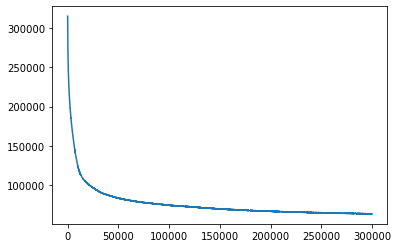

In [23]:
start = 50
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

In [24]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
means = model.get_means(predict_timepoints)

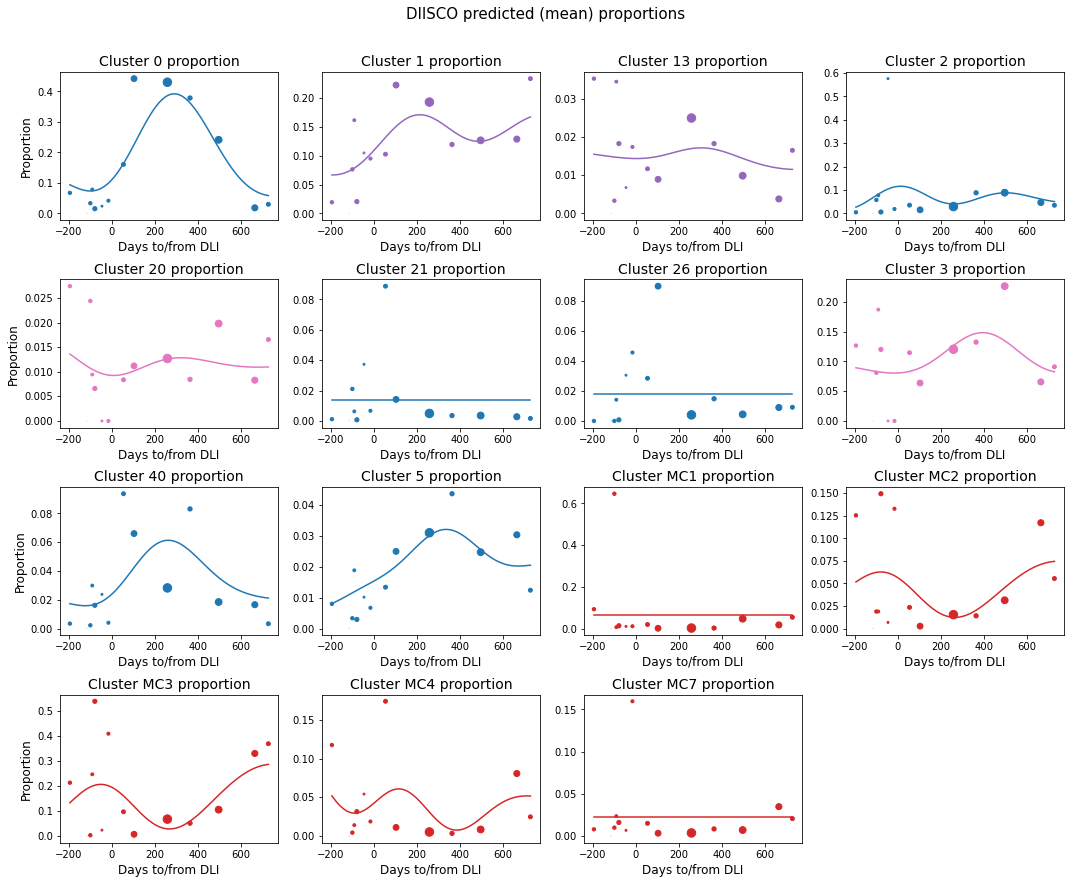

In [25]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    mean = unscale(means['Y'][:, i], i)
    x = predict_timepoints.squeeze().numpy()
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted (mean) proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)

In [26]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                 n_samples=10000, 
                 n_samples_per_latent=10,
                 include_emission_variance=False)

100%|██████████████████████████████████████████████| 10000/10000 [03:36<00:00, 46.28it/s]


In [27]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

In [28]:
y_preds = y_samples_predict.mean(axis=0).numpy()

np.save('../../data/AML/run_1_X_R.npy', predict_timepoints.numpy())
np.save('../../data/AML/run_1_y_preds_R.npy', y_preds)
np.save('../../data/AML/run_1_W_samples_predict_R.npy', W_samples_predict)
np.save('../../data/AML/run_1_y_samples_predict_R.npy', y_samples_predict)

In [19]:
predict_timepoints = np.load('../../data/AML/run_1_X_R.npy')
y_preds = np.load('../../data/AML/run_1_y_preds_R.npy')
W_samples_predict = np.load('../../data/AML/run_1_W_samples_predict_R.npy')
y_samples_predict = np.load('../../data/AML/run_1_y_samples_predict_R.npy')

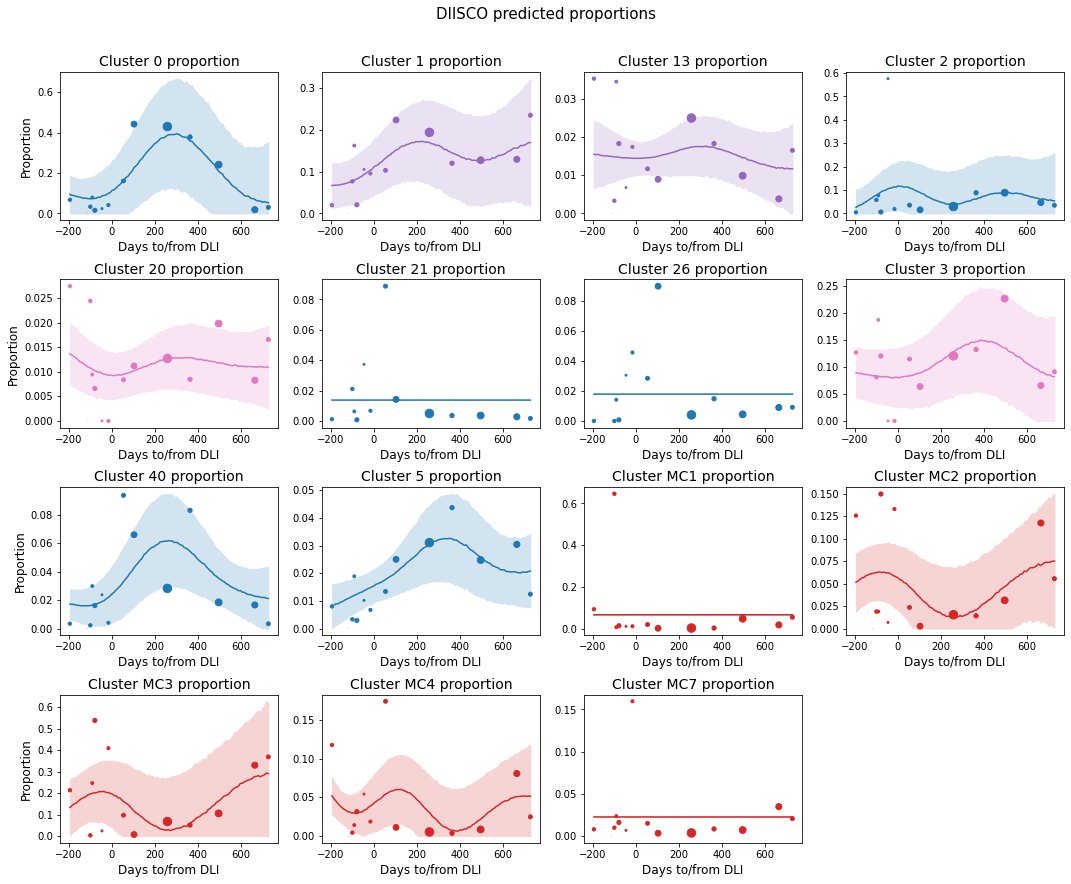

In [20]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    color_with_alpha = list(colors2.to_rgb(color)) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    plt.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)
plt.savefig('../../figures/AML/run_1/diisco_predictions_R.eps')

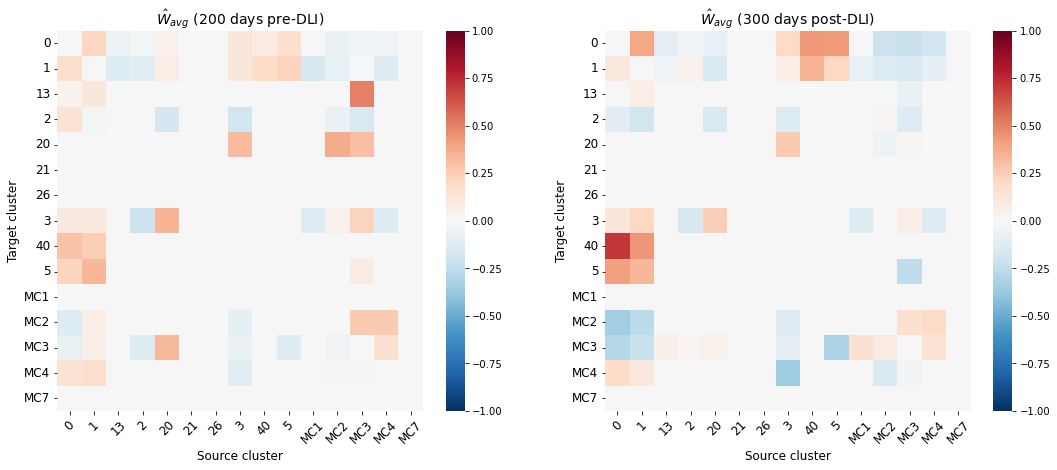

In [21]:
annot = False
vmin = -1
vmax = 1

X_200_days_pre_dli_index = np.where(predict_timepoints > -200)[0][0]
X_post_dli_index = np.where(predict_timepoints > 0)[0][0]
X_300_days_post_dli_index = np.where(predict_timepoints > 300)[0][0]
X_post_dli_index

W = W_samples_predict.mean(axis=0)
W_pre_dli = W[X_200_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_300_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (200 days pre-DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (300 days post-DLI)', fontsize=14)
plt.savefig('../../figures/AML/run_1/W_avg_pre_post_DLI_R.eps')

In [22]:
y_mu = y_samples_predict.mean(axis=0).mean(axis=0)
y_mu = [unscale(y_mu[i], i) for i in range(len(y_mu))]

y_sigma = y_samples_predict.std(axis=0).mean(axis=0)
y_sigma = [unscale(y_sigma[i], i) for i in range(len(y_sigma))]

y_mu_over_sigma = np.array(y_mu) / np.array(y_sigma)

Text(0, 0.5, 'y_mu / y_sigma')

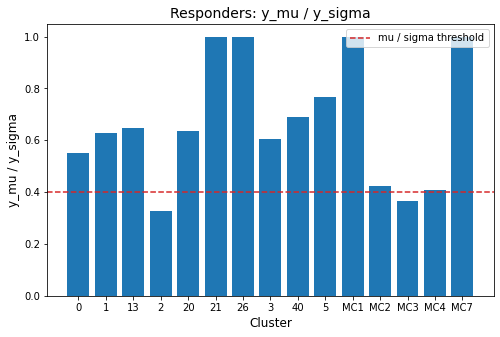

In [23]:
plt.figure(figsize=(8, 5))
mu_sigma_threshold = 0.4
plt.bar(range(len(y_mu_over_sigma)), y_mu_over_sigma)
plt.xticks(range(len(y_mu_over_sigma)), clusters_of_interest)
plt.axhline(mu_sigma_threshold, c='tab:red', linestyle='--', label='mu / sigma threshold')
plt.legend(loc='upper right')
plt.title("Responders: y_mu / y_sigma", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("y_mu / y_sigma", fontsize=12)

In [24]:
mean_abs_W_threshold = 0.25
max_abs_W_threshold = 1
mu_sigma_threshold = 0.4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


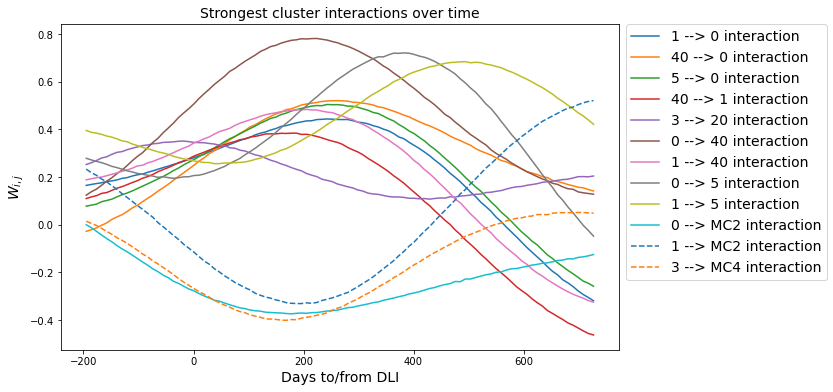

In [25]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(),
                     W[:, i, j],
                     linestyle=linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_1/W_over_time_R_top_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


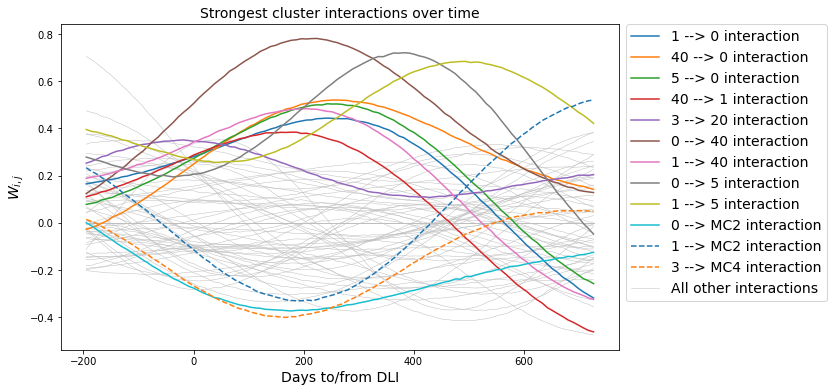

In [26]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_1/W_over_time_R_all_interactions.eps', bbox_inches='tight')

In [27]:
import py4cytoscape as p4c
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

In [28]:
W_pre_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_pre_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_pre_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_pre_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_pre_dli_avg_over_time[row, col])
        })

W_pre_dli_avg_edge_list_df = pd.DataFrame(W_pre_dli_avg_edge_list)

W_avg_edge_list_df = W_pre_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,1,0,0.213124,0.213124,1.0
2,13,0,-0.055113,0.000000,-1.0
3,2,0,-0.027291,0.000000,-1.0
4,20,0,0.047189,0.000000,1.0
5,21,0,0.000000,0.000000,0.0


In [29]:
y_preds_pre_dli = y_preds[X_200_days_pre_dli_index:X_post_dli_index]
y_preds_avg_pre_dli = y_preds_pre_dli.mean(axis=0)
y_preds_avg_pre_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_pre_dli)]
y_preds_avg_pre_dli_df = pd.DataFrame(y_preds_avg_pre_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_pre_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

,id,Inferred cluster proportion
0,0,0.082895
1,1,0.080257
2,13,0.014916
3,2,0.074589
4,20,0.011052
5,21,0.013754
6,26,0.017908
7,3,0.083799
8,40,0.017637
9,5,0.011531


In [30]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.01, 'id']

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [31]:
# Add clusters from NR interaction network diagram
clusters_to_add = {
    '2': 'T cell'
}

proportions_pre_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] < 0]
proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
proportions_pre_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_pre_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/1245073218.py:7: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/1245073218.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/1245073218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({


In [32]:
colors_hex = {
    'T cell': '#CBE0EE',
    'B cell': '#F9E0F2',
    'Myeloid': '#F8CECD',
    'AML': '#E1E1E1',
    'HSC': '#F8EBCB',
    'NK cell': '#E7DDF0'
}

clusters_to_colors_hex = [
    colors_hex[clusters_of_interest[cluster]] if cluster in clusters_of_interest
    else colors_hex[clusters_to_add[cluster]]
    for cluster in y_preds_avg_df['id']
]

# clusters_to_colors_hex = ['#CBE0EE' for cluster in y_preds_avg_df['id']]

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


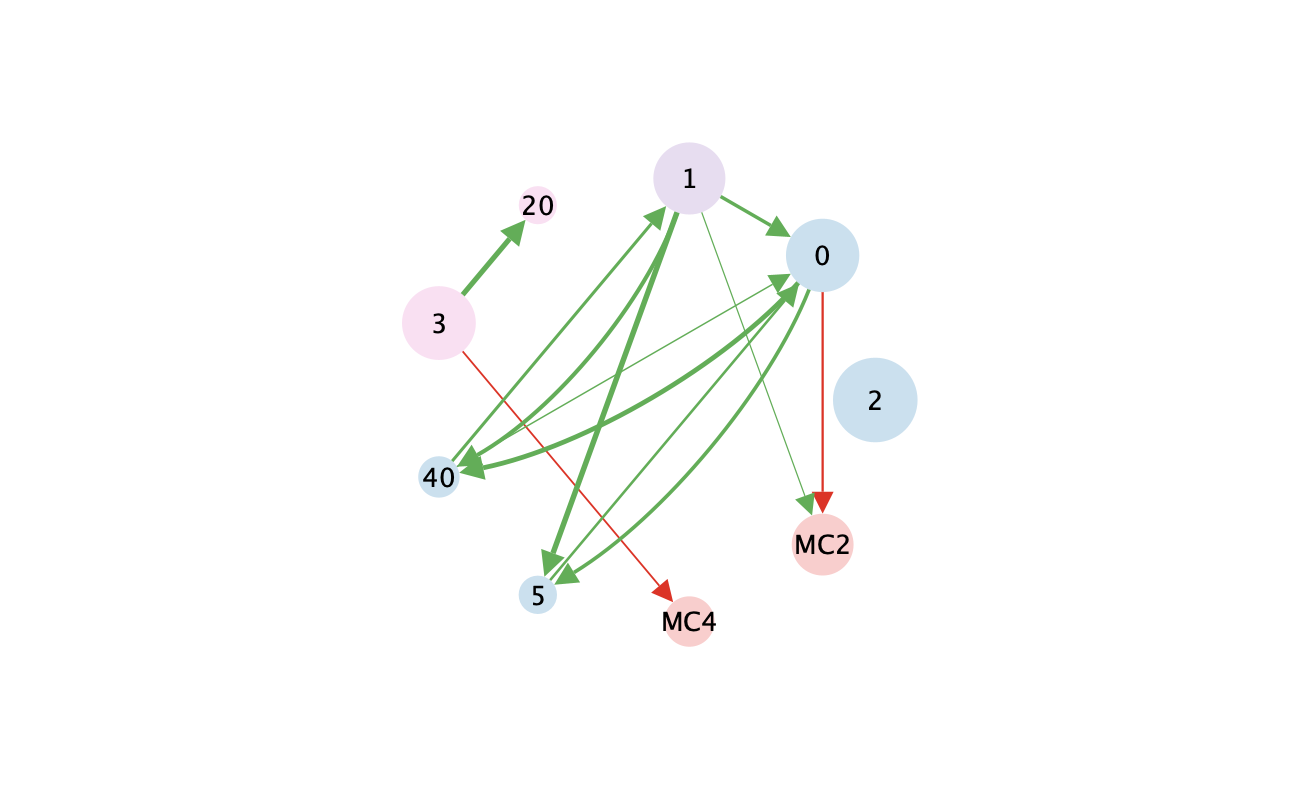

In [33]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Responders Pre DLI", 
                                    collection="AML Responders Pre DLI")

# Default styles
p4c.layout_network('circular')
# p4c.layout_copycat(source_network='AML Responders Pre DLI', 
#                    target_network='AML Responders Pre DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 150 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(2)
p4c.export_image(f'../../figures/AML/run_1/interaction_network_R_pre_avg.svg', type='SVG')
p4c.export_image(f'../../figures/AML/run_1/interaction_network_R_pre_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [34]:
W_post_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_post_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_post_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_post_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_post_dli_avg_over_time[row, col])
        })
        
W_post_dli_avg_edge_list_df = pd.DataFrame(W_post_dli_avg_edge_list)

W_avg_edge_list_df = W_post_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,1,0,0.387771,0.387771,1.0
2,13,0,-0.097681,0.000000,-1.0
3,2,0,-0.037395,0.000000,-1.0
4,20,0,-0.078413,0.000000,-1.0
5,21,0,0.000000,0.000000,0.0


In [35]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_post_dli = y_preds[X_post_dli_index:X_300_days_post_dli_index]
y_preds_avg_post_dli = y_preds_post_dli.mean(axis=0)
y_preds_avg_post_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_post_dli)]
y_preds_avg_post_dli_df = pd.DataFrame(y_preds_avg_post_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_post_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

,id,Inferred cluster proportion
0,0,0.273070
1,1,0.153210
2,13,0.015852
3,2,0.072521
4,20,0.011000
5,21,0.013754
6,26,0.017908
7,3,0.102665
8,40,0.047954
9,5,0.023615


In [36]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.01, 'id']

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [37]:
# Add clusters from NR interaction network diagram
clusters_to_add = {
    '2': 'T cell'
}

proportions_post_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] >= 0]
proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
proportions_post_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_post_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/2512174941.py:7: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/2512174941.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_85561/2512174941.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({


Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


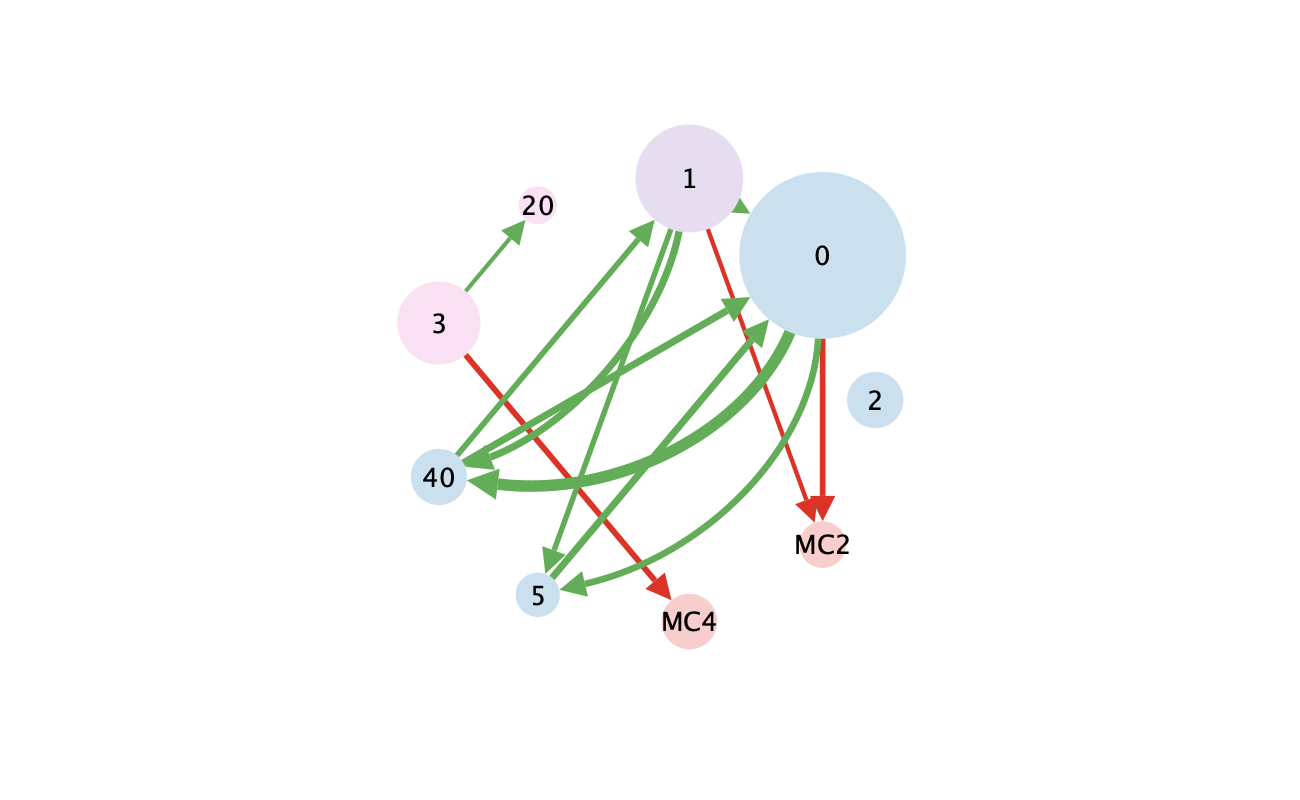

In [38]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Responders Post DLI", 
                                    collection="AML Responders Post DLI")

# Default styles
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Responders Post DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 150 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(2)
p4c.export_image(f'../../figures/AML/run_1/interaction_network_R_post_avg.svg', type='SVG')
p4c.export_image(f'../../figures/AML/run_1/interaction_network_R_post_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [85]:
include_clusters = ['0', '1', '20', '3', '40', '5', 'MC4', 'MC2', '2']

In [87]:
for days_to_dli in range(-200, 710, 10):
    days_nearest_X_index = np.argmin(np.abs(predict_timepoints - days_to_dli))
    W_t = W[days_nearest_X_index]
    y_t = y_preds[days_nearest_X_index]
    y_t = [unscale(y, i) for i, y in enumerate(y_t)]

    W_edge_list = []
    for row, target_cluster in enumerate(clusters_of_interest.keys()):
        for col, source_cluster in enumerate(clusters_of_interest.keys()):
            sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
            transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
            confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                         y_mu_over_sigma[col] > mu_sigma_threshold)
            show_edge = (sustained or transient) and confident
            W_edge_list.append({
                'Source cluster': source_cluster,
                'Target cluster': target_cluster,
                'Interaction weight': W_t[row, col],
                'abs(Interaction weight)': np.abs(W_t[row, col]) * show_edge,
                'sign(Interaction weight)': np.sign(W_t[row, col])
            })

    W_edge_list_df = pd.DataFrame(W_edge_list)
    W_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                                  'abs(Interaction weight)', 'sign(Interaction weight)']
    W_edge_list_df[['source', 'target']] = W_edge_list_df[['source', 'target']].astype(str)
    W_edge_list_df = W_edge_list_df[W_edge_list_df['source'] != W_edge_list_df['target']]
    W_edge_list_df.head()

    y_t_df = pd.DataFrame(y_t, index=clusters_of_interest, 
                          columns=['Inferred cluster proportion'])
    y_t_df = y_t_df.reset_index()
    y_t_df.columns = ['id', 'Inferred cluster proportion']
    y_t_df['id'] = y_t_df['id'].astype(str)

    # Keep clusters consistent across timestamps
    W_edge_list_df = W_edge_list_df[(W_edge_list_df['source'].isin(include_clusters)) & 
                                    (W_edge_list_df['target'].isin(include_clusters))]
    y_t_df = y_t_df[(y_t_df['id'].isin(include_clusters))]
    

    p4c.create_network_from_data_frames(nodes=y_t_df, 
                                        edges=W_edge_list_df, 
                                        title="AML Responders", 
                                        collection="AML Responders")
    
    p4c.add_annotation_text('AML Responders Interaction Network', -70, -130, 9)
    p4c.add_annotation_text(f'{days_to_dli} days to/from DLI', -37, -120, 9)

    # Default styles
    p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                       target_network='AML Responders')
    p4c.set_node_shape_default('ELLIPSE')
    p4c.set_node_width_default(20)
    p4c.set_node_height_default(20)
    p4c.set_node_font_size_default(8)
    p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

    # Map style properties to node/edge attributes
    p4c.set_node_color_mapping(table_column='shared name', 
                               table_column_values=list(y_t_df['id']), 
                               colors=clusters_to_colors_hex, 
                               mapping_type='d')
    p4c.set_node_size_mapping(table_column='SUID',
                              table_column_values=list(p4c.get_table_columns()['SUID']),
                              sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 100 + 10))
    p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                               table_column_values=[-1.0, 1.0],
                               colors=['#DB3427', '#63AD58'])
    p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                            table_column_values=[-1.0, 1.0],
                                            colors=['#DB3427', '#63AD58'])
    p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                    table_column_values=[W_edge_list_df['abs(Interaction weight)'].min(), 
                                                         W_edge_list_df['abs(Interaction weight)'].max()],
                                    widths=[W_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                            W_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                    mapping_type='c')
    edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                     for i, row in W_edge_list_df.iterrows()
                     if row['abs(Interaction weight)'] == 0]
    p4c.hide_edges(edges_to_hide)

    p4c.set_network_center_bypass(0, 0)
    p4c.set_network_zoom_bypass(1.75)
    p4c.export_image(f'../../figures/AML/run_1/interaction_networks_R/png/{days_to_dli}', type='PNG')
    p4c.delete_network()

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not s

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


## Non-responders model

In [53]:
cells_df_nonresponders = cells_df[cells_df['response'] == 'NONRESPONDER']
cells_df_nonresponders

,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
5965,-1.632356,-5.798063,JS1_,13,aml1,JS,PRE,NONRESPONDER,x,AML,NK cells,0.0,donor,AML_NR_PRE,BM,13,-182
5966,-1.897697,-6.293473,JS1_,13,aml1,JS,PRE,NONRESPONDER,x,AML,NK cells,0.0,donor,AML_NR_PRE,BM,13,-182
5967,-1.806480,-6.332476,JS1_,13,aml1,JS,PRE,NONRESPONDER,x,AML,CD16+ NK cells,0.0,donor,AML_NR_PRE,BM,13,-182
5968,7.023400,7.565010,JS1_,24,aml1,JS,PRE,NONRESPONDER,x,AML,Non-classical monocytes,0.0,donor,AML_NR_PRE,BM,MC2,-182
5969,10.761170,-2.786308,JS1_,11,aml1,JS,PRE,NONRESPONDER,x,AML,Mid erythroid,0.0,donor,AML_NR_PRE,BM,MC4,-182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34814,0.216889,-2.060157,GD3_,1,aml1,GD,PRE,NONRESPONDER,x,AML,CD16+ NK cells,0.0,tumor,AML_NR_PRE,BM,1,-179
34815,-1.474262,1.229219,GD3_,0,aml1,GD,PRE,NONRESPONDER,x,AML,Tem/Temra cytotoxic T cells,0.0,tumor,AML_NR_PRE,BM,0,-179
34816,-1.091123,-4.655160,GD3_,1,aml1,GD,PRE,NONRESPONDER,x,AML,CD16+ NK cells,0.0,tumor,AML_NR_PRE,BM,1,-179
34817,11.836526,12.776303,GD3_,23,aml1,GD,PRE,NONRESPONDER,x,AML,Large pre-B cells,0.0,tumor,AML_NR_PRE,BM,23,-179


In [54]:
clusters_of_interest = {
    '0': 'T cell',
    '1': 'NK cell',
    '13': 'NK cell',
    '14': 'B cell',
    '2': 'T cell',
    '23': 'B cell',
    '26': 'T cell',
    '3': 'B cell',
    '38': 'B cell',
    '40': 'T cell',
    '5': 'T cell',
    'MC1': 'Myeloid',
    'MC2': 'Myeloid',
    'MC3': 'Myeloid',
    'MC4': 'Myeloid',
    'MC5': 'Myeloid', 
    'MC6': 'Myeloid',
    'MC7': 'Myeloid'
}

colors = {
    'T cell': 'tab:blue',
    'B cell': 'tab:pink',
    'Myeloid': 'tab:red',
    'AML': 'tab:gray',
    'HSC': 'goldenrod',
    'NK cell': 'tab:purple'
}

In [55]:
sample_cluster_proportions = []

all_clusters = sorted(cells_df_nonresponders['diisco_cluster'].unique())
for sample, sample_df in cells_df_nonresponders.groupby('sample'):
    cluster_proportions = sample_df['diisco_cluster'].value_counts(normalize=True)
    cluster_proportions_dict = {cluster: (cluster_proportions[cluster] 
                                          if cluster in cluster_proportions
                                          else 0)
                                for cluster in all_clusters}
    sample_cluster_proportions.append({
        'sample': sample,
        'days_to_DLI': sample_df.iloc[0]['days_to_DLI'],
        **cluster_proportions_dict
    })
    
sample_cluster_proportions_all_df = pd.DataFrame(sample_cluster_proportions)
sample_cluster_proportions_all_df = sample_cluster_proportions_all_df.sort_values('days_to_DLI')
sample_cluster_proportions_all_df

,sample,days_to_DLI,0,1,13,14,18,2,20,21,...,49,5,MC1,MC2,MC3,MC4,MC5,MC6,MC7,MC8
8,JS1_,-182,0.019417,0.274272,0.067961,0.023058,0.000000,0.019417,0.000000,0.014563,...,0.000000,0.001214,0.013350,0.080097,0.302184,0.061893,0.002427,0.000000,0.089806,0.000000
7,GD3_,-179,0.050505,0.606061,0.111111,0.010101,0.000000,0.020202,0.030303,0.010101,...,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,GD1_,-109,0.019608,0.533469,0.067613,0.002028,0.000000,0.160920,0.000676,0.013523,...,0.000000,0.015551,0.041920,0.058147,0.031778,0.001352,0.000000,0.000676,0.000000,0.000000
1,AH2_,-106,0.190226,0.047943,0.016703,0.045159,0.000000,0.038973,0.000928,0.003402,...,0.000000,0.061243,0.031859,0.031240,0.028457,0.254562,0.047634,0.023508,0.003402,0.000309
3,AM1_,-70,0.069767,0.051163,0.000000,0.000000,0.013953,0.144186,0.004651,0.004651,...,0.009302,0.065116,0.106977,0.060465,0.009302,0.106977,0.018605,0.018605,0.000000,0.000000
0,AH1_,-15,0.327485,0.081871,0.023392,0.023392,0.000000,0.081871,0.000000,0.000000,...,0.000000,0.169591,0.005848,0.000000,0.005848,0.005848,0.000000,0.000000,0.000000,0.000000
4,AM2_,0,0.041860,0.055814,0.009302,0.000000,0.000000,0.255814,0.000000,0.004651,...,0.000000,0.051163,0.027907,0.000000,0.000000,0.186047,0.065116,0.065116,0.000000,0.060465
6,GD2_,28,0.053030,0.375000,0.003788,0.003788,0.000000,0.276515,0.000000,0.030303,...,0.000000,0.056818,0.000000,0.000000,0.015152,0.003788,0.000000,0.000000,0.007576,0.003788
2,AH3_,48,0.477273,0.090909,0.000000,0.000000,0.000000,0.060606,0.022727,0.030303,...,0.000000,0.007576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,JS2_,98,0.014184,0.742317,0.016548,0.000000,0.000000,0.054374,0.000000,0.026005,...,0.000000,0.007092,0.002364,0.000000,0.009456,0.014184,0.000000,0.000000,0.000000,0.000000


In [56]:
sample_cluster_proportions_df = sample_cluster_proportions_all_df[['sample', 'days_to_DLI'] 
                                                                  + list(clusters_of_interest.keys())]
sample_cluster_proportions_df

,sample,days_to_DLI,0,1,13,14,2,23,26,3,38,40,5,MC1,MC2,MC3,MC4,MC5,MC6,MC7
8,JS1_,-182,0.019417,0.274272,0.067961,0.023058,0.019417,0.001214,0.006068,0.000000,0.008495,0.006068,0.001214,0.013350,0.080097,0.302184,0.061893,0.002427,0.000000,0.089806
7,GD3_,-179,0.050505,0.606061,0.111111,0.010101,0.020202,0.020202,0.040404,0.000000,0.010101,0.020202,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,GD1_,-109,0.019608,0.533469,0.067613,0.002028,0.160920,0.005409,0.003381,0.002705,0.002705,0.007437,0.015551,0.041920,0.058147,0.031778,0.001352,0.000000,0.000676,0.000000
1,AH2_,-106,0.190226,0.047943,0.016703,0.045159,0.038973,0.050108,0.006805,0.056913,0.009279,0.042685,0.061243,0.031859,0.031240,0.028457,0.254562,0.047634,0.023508,0.003402
3,AM1_,-70,0.069767,0.051163,0.000000,0.000000,0.144186,0.000000,0.000000,0.144186,0.060465,0.000000,0.065116,0.106977,0.060465,0.009302,0.106977,0.018605,0.018605,0.000000
0,AH1_,-15,0.327485,0.081871,0.023392,0.023392,0.081871,0.011696,0.000000,0.152047,0.011696,0.099415,0.169591,0.005848,0.000000,0.005848,0.005848,0.000000,0.000000,0.000000
4,AM2_,0,0.041860,0.055814,0.009302,0.000000,0.255814,0.000000,0.009302,0.046512,0.055814,0.046512,0.051163,0.027907,0.000000,0.000000,0.186047,0.065116,0.065116,0.000000
6,GD2_,28,0.053030,0.375000,0.003788,0.003788,0.276515,0.007576,0.037879,0.000000,0.003788,0.083333,0.056818,0.000000,0.000000,0.015152,0.003788,0.000000,0.000000,0.007576
2,AH3_,48,0.477273,0.090909,0.000000,0.000000,0.060606,0.000000,0.022727,0.212121,0.060606,0.015152,0.007576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,JS2_,98,0.014184,0.742317,0.016548,0.000000,0.054374,0.000000,0.063830,0.000000,0.002364,0.035461,0.007092,0.002364,0.000000,0.009456,0.014184,0.000000,0.000000,0.000000


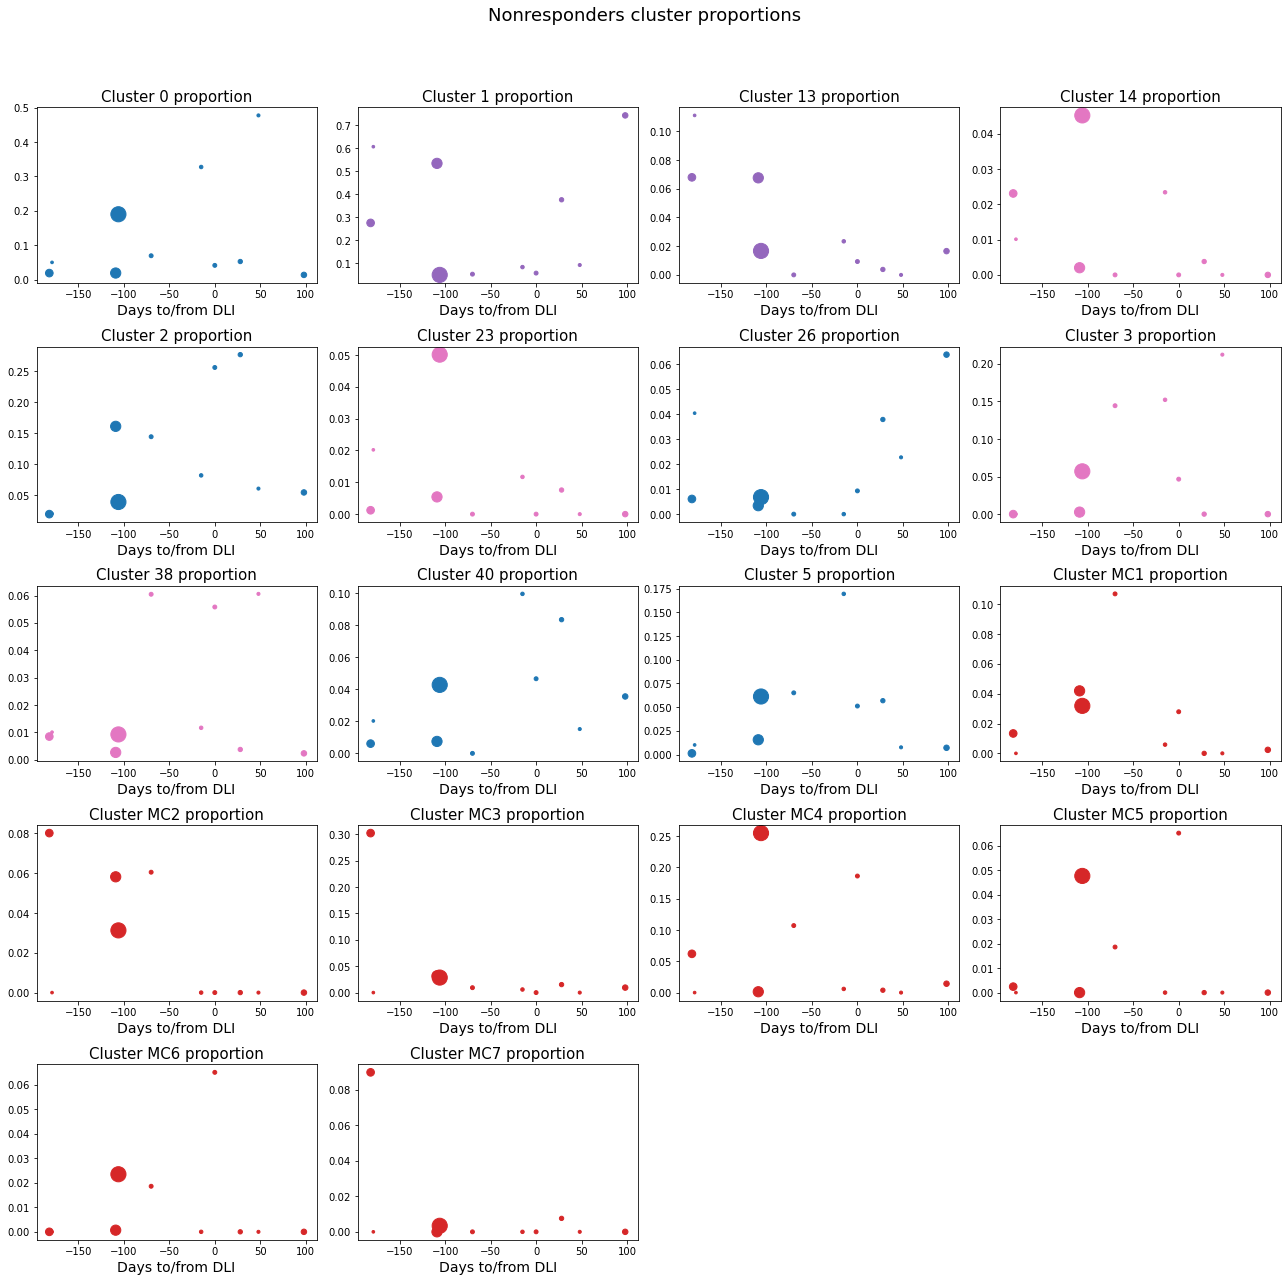

In [57]:
cells_per_sample = cells_df_nonresponders['sample'].value_counts(normalize=True)[sample_cluster_proportions_df['sample']]

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    color = colors[list(clusters_of_interest.values())[i]]
    plt.subplot(6, 4, i+1)
    plt.scatter(sample_cluster_proportions_df['days_to_DLI'], 
                sample_cluster_proportions_df[cluster], 
                s=cells_per_sample*500, 
                color=color)
    plt.title(f'Cluster {cluster} proportion', fontsize=15)
    plt.xlabel('Days to/from DLI', fontsize=14)
plt.suptitle(f'Nonresponders cluster proportions', y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig('../../figures/AML/run_1/cell_type_proportions_NR.eps', bbox_inches='tight')

In [58]:
cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
sample_cluster_proportions_df.loc[:, clusters_of_interest] /= cluster_std_devs
sample_cluster_proportions_df

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/858897236.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/858897236.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a 

,sample,days_to_DLI,0,1,13,14,2,23,26,3,38,40,5,MC1,MC2,MC3,MC4,MC5,MC6,MC7
8,JS1_,-182,-0.676872,-0.044074,0.965904,0.808964,-0.972169,-0.535477,-0.599463,-0.775175,-0.553289,-0.882006,-0.853356,-0.291462,1.791750,2.824857,-0.017258,-0.461331,-0.513445,2.834918
7,GD3_,-179,-0.480064,1.215482,2.113467,-0.042840,-0.963867,0.673995,0.987327,-0.775175,-0.489988,-0.460256,-0.678336,-0.693705,-0.721537,-0.433679,-0.696791,-0.563580,-0.513445,-0.358364
5,GD1_,-109,-0.675667,0.939904,0.956651,-0.573530,0.525201,-0.268246,-0.723653,-0.741057,-0.781549,-0.841141,-0.571008,0.569422,1.103013,-0.091005,-0.681944,-0.563580,-0.481272,-0.358364
1,AH2_,-106,0.404472,-0.903277,-0.397303,2.261878,-0.765232,2.578879,-0.565410,-0.057212,-0.522378,0.210615,0.328813,0.266259,0.258722,-0.126824,2.098078,1.443079,0.605121,-0.237382
3,AM1_,-70,-0.358119,-0.891055,-0.841509,-0.706876,0.348128,-0.612777,-0.879885,1.043742,1.495308,-1.063070,0.405081,2.529684,1.175738,-0.333369,0.477719,0.220174,0.371824,-0.358364
0,AH1_,-15,1.273428,-0.774477,-0.219409,0.830892,-0.311284,0.132196,-0.879885,1.142905,-0.427119,1.903411,2.462497,-0.517496,-0.721537,-0.370618,-0.632586,-0.563580,-0.513445,-0.358364
4,AM2_,0,-0.534791,-0.873398,-0.594116,-0.706876,1.529371,-0.612777,-0.449992,-0.188427,1.311964,0.324805,0.130295,0.147179,-0.721537,-0.433679,1.345835,2.179561,2.584995,-0.358364
6,GD2_,28,-0.464078,0.338316,-0.740771,-0.457862,1.748430,-0.130238,0.870627,-0.775175,-0.738844,1.423539,0.241667,-0.693705,-0.721537,-0.270296,-0.655203,-0.563580,-0.513445,-0.088988
2,AH3_,48,2.221693,-0.740167,-0.841509,-0.706876,-0.536313,-0.612777,0.170422,1.900748,1.500864,-0.610959,-0.728065,-0.693705,-0.721537,-0.433679,-0.696791,-0.563580,-0.513445,-0.358364
9,JS2_,98,-0.710001,1.732746,-0.401406,-0.706876,-0.602265,-0.612777,2.069914,-0.775175,-0.794969,-0.004938,-0.737588,-0.622472,-0.721537,-0.331709,-0.541059,-0.563580,-0.513445,-0.358364


In [59]:
X = sample_cluster_proportions_df['days_to_DLI'].values.reshape(-1, 1)
X

array([[-182],
       [-179],
       [-109],
       [-106],
       [ -70],
       [ -15],
       [   0],
       [  28],
       [  48],
       [  98]])

In [60]:
Y = sample_cluster_proportions_df[clusters_of_interest].values
Y[:5]

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/2580917083.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  Y = sample_cluster_proportions_df[clusters_of_interest].values


array([[-0.67687201, -0.04407444,  0.96590364,  0.80896433, -0.97216912,
        -0.53547724, -0.59946347, -0.77517467, -0.55328912, -0.88200632,
        -0.85335567, -0.29146156,  1.7917504 ,  2.82485731, -0.01725833,
        -0.46133087, -0.51344464,  2.83491763],
       [-0.48006448,  1.21548224,  2.11346713, -0.0428395 , -0.96386709,
         0.67399481,  0.98732744, -0.77517467, -0.48998777, -0.46025569,
        -0.67833557, -0.69370484, -0.72153727, -0.43367852, -0.6967909 ,
        -0.5635804 , -0.51344464, -0.35836392],
       [-0.67566684,  0.9399039 ,  0.95665097, -0.57352977,  0.52520131,
        -0.268246  , -0.72365298, -0.74105685, -0.78154858, -0.84114148,
        -0.57100787,  0.56942164,  1.10301267, -0.09100539, -0.68194422,
        -0.5635804 , -0.4812721 , -0.35836392],
       [ 0.40447203, -0.90327744, -0.39730276,  2.26187786, -0.76523222,
         2.57887915, -0.56541039, -0.05721241, -0.52237836,  0.21061544,
         0.32881306,  0.26625894,  0.25872243, -0.126

Text(0.5, 1.02, 'Interaction prior variances for nonresponders based on receptor-ligand expression')

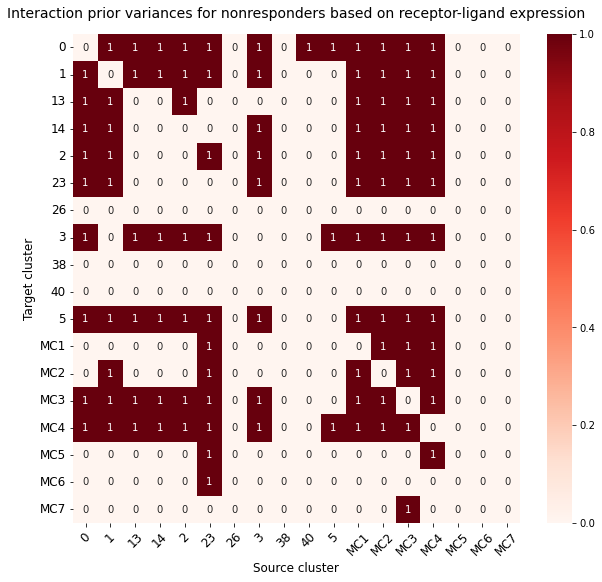

In [61]:
W_prior_variance = np.load('../../data/AML/nonresponder_interaction_prior_run_1.npy')

plt.figure(figsize=(10, 9))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('Interaction prior variances for nonresponders based on receptor-ligand expression', 
          fontsize=14, y=1.02)

In [62]:
timepoints = torch.tensor(X)
proportions = torch.tensor(Y)
prior_matrix = torch.tensor(W_prior_variance)
n_timepoints, n_cell_types = proportions.shape

print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([10, 1])
cell_types.shape: torch.Size([10, 18])


In [63]:
def unscale(proportions, cluster_index): 
    return np.clip((proportions * 
                    cluster_std_devs.values[cluster_index] + 
                    cluster_means.values[cluster_index]), 
                   0, 1)

In [64]:
# mean of all intervals
lengthscale = np.mean(np.abs(X - X.T))
lengthscale

103.34

In [65]:
hyper_init_vals = {
    names.LENGTHSCALE_F: 100,
    names.LENGTHSCALE_W: 100,
    names.SIGMA_F: 1,
    names.VARIANCE_F: 1,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 1,
    names.SIGMA_Y: 0.5,
}
print(hyper_init_vals)

{'lengthscale_f': 100, 'lengthscale_w': 100, 'sigma_f': 1, 'variance_f': 1, 'sigma_w': 0.1, 'variance_w': 1, 'sigma_y': 0.5}


In [43]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

Text(0.5, 0.95, 'Independent GP fits to set $f_i$ latent functions')

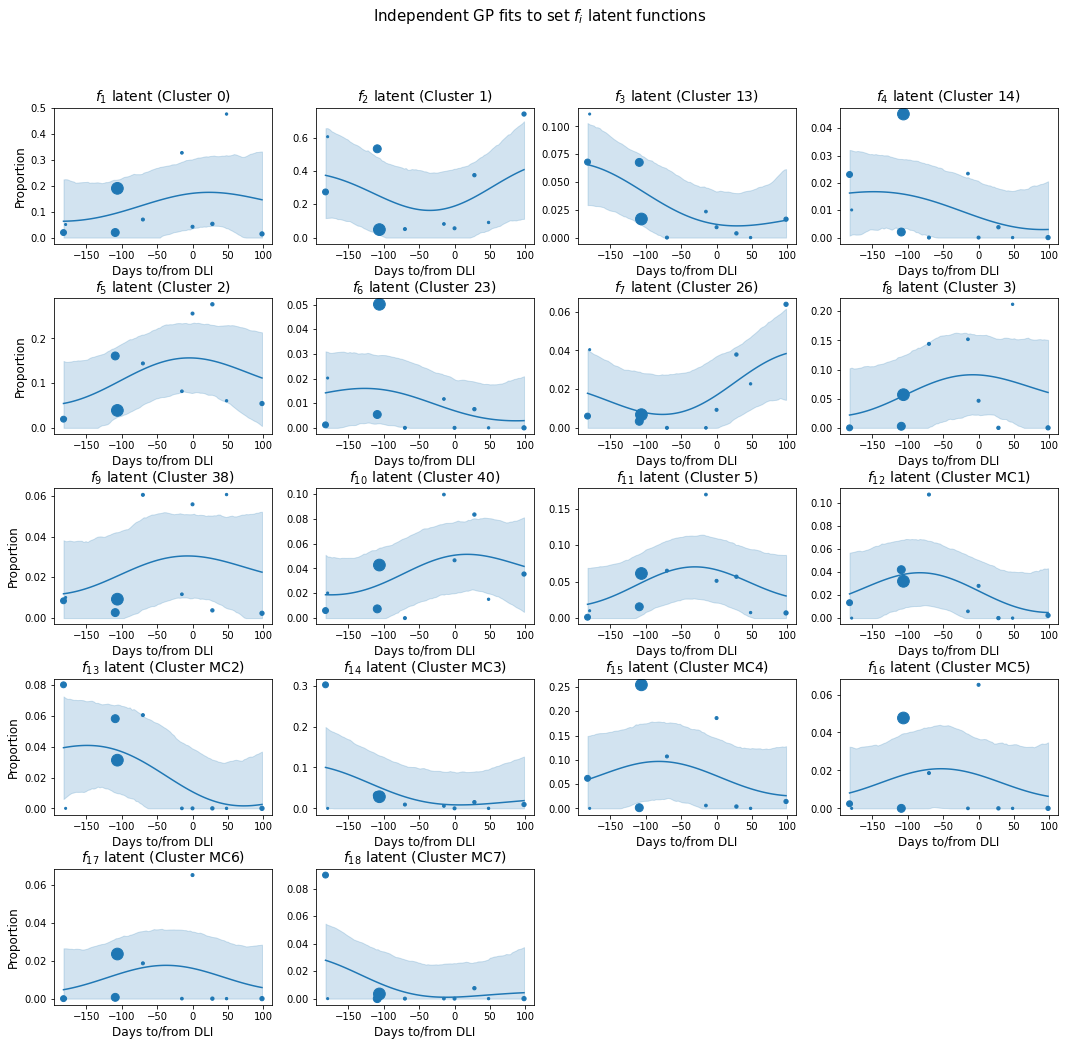

In [44]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
eval_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).view(-1, 1)

n_samples = 1000
n_eval_timepoints = eval_timepoints.shape[0]
f_prior_np = model.sample_f_prior(eval_timepoints, n_samples=n_samples)

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    eval_timepoints_np = eval_timepoints.detach().numpy()
    f_prior_cell_type_np = f_prior_np[:, i, :].detach().numpy()
    mean = unscale(f_prior_cell_type_np.mean(axis=0), i)
    upper = unscale(np.percentile(f_prior_cell_type_np, 97.5, axis=0), i)
    lower = unscale(np.percentile(f_prior_cell_type_np, 2.5, axis=0), i)
    plt.subplot(6, 4, i+1)
#     color = colors[list(clusters_of_interest.values())[i]]
    color = 'tab:blue'
    plt.plot(eval_timepoints_np, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i].flatten().detach().numpy(), i), 
                c=color, s=cells_per_sample*300)
    plt.fill_between(eval_timepoints_np.flatten(), lower, upper, color=color, alpha=0.2)
    plt.title('$f_{%s}$ latent (Cluster %s)' % (i+1, cluster), fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
plt.subplots_adjust(hspace=0.4)
plt.suptitle('Independent GP fits to set $f_i$ latent functions', fontsize=15, y=0.95)

In [45]:
model.fit(timepoints, 
          proportions, 
          n_iter=300000, 
          lr=0.00001, 
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 1076604.5790
[iteration 0101] loss: 697737.2647
[iteration 0201] loss: 650113.3834
[iteration 0301] loss: 621521.2497
[iteration 0401] loss: 601460.1637
[iteration 0501] loss: 583205.9132
[iteration 0601] loss: 573492.3838
[iteration 0701] loss: 561256.9866
[iteration 0801] loss: 551770.2618
[iteration 0901] loss: 545082.4304
[iteration 1001] loss: 535614.6759
[iteration 1101] loss: 528283.7062
[iteration 1201] loss: 520525.4148
[iteration 1301] loss: 514914.5786
[iteration 1401] loss: 511522.6834
[iteration 1501] loss: 504712.8326
[iteration 1601] loss: 501300.0527
[iteration 1701] loss: 494263.0906
[iteration 1801] loss: 490490.5294
[iteration 1901] loss: 484575.3769
[iteration 2001] loss: 481860.7101
[iteration 2101] loss: 475816.6615
[iteration 2201] loss: 471416.7198
[iteration 2301] loss: 468246.4314
[iteration 2401] loss: 465688.5839
[iteration 2501] loss: 460251.1271
[iteration 2601] loss: 455552.8916
[iteration 2701] loss: 453784.6891
[iteration 2801] lo

[iteration 23101] loss: 213192.4554
[iteration 23201] loss: 210283.2219
[iteration 23301] loss: 210043.7767
[iteration 23401] loss: 211590.8497
[iteration 23501] loss: 210423.7621
[iteration 23601] loss: 209893.5262
[iteration 23701] loss: 208883.3192
[iteration 23801] loss: 208858.6902
[iteration 23901] loss: 209099.6023
[iteration 24001] loss: 208355.1003
[iteration 24101] loss: 209301.1221
[iteration 24201] loss: 207872.9010
[iteration 24301] loss: 208229.6840
[iteration 24401] loss: 205825.1955
[iteration 24501] loss: 209292.6443
[iteration 24601] loss: 208900.8383
[iteration 24701] loss: 206139.2574
[iteration 24801] loss: 205143.9674
[iteration 24901] loss: 205334.6048
[iteration 25001] loss: 204798.1862
[iteration 25101] loss: 205346.6624
[iteration 25201] loss: 203776.1508
[iteration 25301] loss: 204915.7009
[iteration 25401] loss: 206068.1205
[iteration 25501] loss: 205241.7848
[iteration 25601] loss: 203473.3815
[iteration 25701] loss: 204374.8831
[iteration 25801] loss: 2038

[iteration 45901] loss: 177996.9189
[iteration 46001] loss: 178541.8951
[iteration 46101] loss: 176816.7085
[iteration 46201] loss: 178256.0029
[iteration 46301] loss: 178614.0104
[iteration 46401] loss: 177701.7760
[iteration 46501] loss: 177674.8863
[iteration 46601] loss: 177575.5841
[iteration 46701] loss: 177826.5040
[iteration 46801] loss: 176489.1586
[iteration 46901] loss: 176669.8394
[iteration 47001] loss: 176644.3507
[iteration 47101] loss: 177737.7495
[iteration 47201] loss: 176543.4236
[iteration 47301] loss: 177014.9541
[iteration 47401] loss: 177501.5529
[iteration 47501] loss: 175646.1180
[iteration 47601] loss: 176988.5322
[iteration 47701] loss: 176281.5350
[iteration 47801] loss: 175088.5035
[iteration 47901] loss: 177123.6937
[iteration 48001] loss: 176029.6941
[iteration 48101] loss: 177344.0556
[iteration 48201] loss: 176488.8333
[iteration 48301] loss: 178040.4973
[iteration 48401] loss: 176452.2935
[iteration 48501] loss: 177096.5842
[iteration 48601] loss: 1765

[iteration 68701] loss: 169002.4471
[iteration 68801] loss: 168744.3667
[iteration 68901] loss: 169315.0951
[iteration 69001] loss: 168088.6984
[iteration 69101] loss: 168571.6003
[iteration 69201] loss: 169471.2617
[iteration 69301] loss: 167918.1519
[iteration 69401] loss: 170502.1779
[iteration 69501] loss: 168753.3448
[iteration 69601] loss: 168981.6158
[iteration 69701] loss: 167361.0397
[iteration 69801] loss: 168451.6866
[iteration 69901] loss: 168571.8505
[iteration 70001] loss: 167846.6384
[iteration 70101] loss: 169324.7118
[iteration 70201] loss: 168309.8721
[iteration 70301] loss: 166802.5607
[iteration 70401] loss: 168441.6996
[iteration 70501] loss: 167006.2791
[iteration 70601] loss: 167364.5830
[iteration 70701] loss: 166121.8513
[iteration 70801] loss: 169137.7913
[iteration 70901] loss: 168246.0942
[iteration 71001] loss: 169160.8679
[iteration 71101] loss: 168925.4000
[iteration 71201] loss: 167132.0065
[iteration 71301] loss: 169277.3342
[iteration 71401] loss: 1688

[iteration 91501] loss: 163374.3363
[iteration 91601] loss: 163051.2601
[iteration 91701] loss: 162527.0753
[iteration 91801] loss: 163158.1128
[iteration 91901] loss: 161695.6570
[iteration 92001] loss: 164643.0980
[iteration 92101] loss: 163063.0863
[iteration 92201] loss: 162707.0285
[iteration 92301] loss: 164351.1536
[iteration 92401] loss: 163708.4742
[iteration 92501] loss: 162516.0465
[iteration 92601] loss: 163416.4082
[iteration 92701] loss: 162984.4399
[iteration 92801] loss: 163907.4728
[iteration 92901] loss: 164625.5858
[iteration 93001] loss: 163229.6351
[iteration 93101] loss: 162563.6546
[iteration 93201] loss: 161744.6556
[iteration 93301] loss: 163514.6554
[iteration 93401] loss: 163671.9527
[iteration 93501] loss: 162370.4241
[iteration 93601] loss: 160537.5683
[iteration 93701] loss: 162620.2669
[iteration 93801] loss: 162343.6189
[iteration 93901] loss: 163707.6385
[iteration 94001] loss: 161997.0786
[iteration 94101] loss: 163734.7510
[iteration 94201] loss: 1637

[iteration 113901] loss: 159757.9302
[iteration 114001] loss: 160245.5383
[iteration 114101] loss: 161479.3630
[iteration 114201] loss: 160099.0255
[iteration 114301] loss: 158907.7780
[iteration 114401] loss: 160416.4042
[iteration 114501] loss: 160801.9249
[iteration 114601] loss: 159374.8310
[iteration 114701] loss: 159621.8142
[iteration 114801] loss: 159759.4650
[iteration 114901] loss: 159045.9785
[iteration 115001] loss: 159849.0215
[iteration 115101] loss: 158557.9327
[iteration 115201] loss: 160192.9087
[iteration 115301] loss: 159251.7577
[iteration 115401] loss: 159246.2866
[iteration 115501] loss: 160809.6527
[iteration 115601] loss: 159613.7532
[iteration 115701] loss: 159807.3130
[iteration 115801] loss: 158463.1654
[iteration 115901] loss: 159981.4321
[iteration 116001] loss: 160378.5045
[iteration 116101] loss: 159478.9141
[iteration 116201] loss: 158389.7524
[iteration 116301] loss: 158672.1490
[iteration 116401] loss: 159383.1495
[iteration 116501] loss: 158632.1242
[

[iteration 136101] loss: 157254.1671
[iteration 136201] loss: 157179.0861
[iteration 136301] loss: 157616.2357
[iteration 136401] loss: 158152.2767
[iteration 136501] loss: 157689.4894
[iteration 136601] loss: 156985.2094
[iteration 136701] loss: 159373.4889
[iteration 136801] loss: 157356.4308
[iteration 136901] loss: 156647.6954
[iteration 137001] loss: 157793.0078
[iteration 137101] loss: 157772.2961
[iteration 137201] loss: 157393.8605
[iteration 137301] loss: 156471.8682
[iteration 137401] loss: 157500.2328
[iteration 137501] loss: 157475.4987
[iteration 137601] loss: 157644.7079
[iteration 137701] loss: 158044.1931
[iteration 137801] loss: 157353.9247
[iteration 137901] loss: 155447.2982
[iteration 138001] loss: 157260.6010
[iteration 138101] loss: 156692.4139
[iteration 138201] loss: 157460.9499
[iteration 138301] loss: 157115.4268
[iteration 138401] loss: 156998.7142
[iteration 138501] loss: 156888.4951
[iteration 138601] loss: 156919.9514
[iteration 138701] loss: 155972.5126
[

[iteration 158301] loss: 155345.8550
[iteration 158401] loss: 155550.3080
[iteration 158501] loss: 156163.7807
[iteration 158601] loss: 153982.0958
[iteration 158701] loss: 154275.3555
[iteration 158801] loss: 153836.9083
[iteration 158901] loss: 154539.8352
[iteration 159001] loss: 157497.2269
[iteration 159101] loss: 156400.9042
[iteration 159201] loss: 153537.5177
[iteration 159301] loss: 155108.3551
[iteration 159401] loss: 152759.8343
[iteration 159501] loss: 154654.2272
[iteration 159601] loss: 154625.7997
[iteration 159701] loss: 154626.2992
[iteration 159801] loss: 154914.6579
[iteration 159901] loss: 154986.5586
[iteration 160001] loss: 155180.1296
[iteration 160101] loss: 155707.7760
[iteration 160201] loss: 153267.5738
[iteration 160301] loss: 154245.7326
[iteration 160401] loss: 155324.9798
[iteration 160501] loss: 154056.5805
[iteration 160601] loss: 154128.7921
[iteration 160701] loss: 154344.6311
[iteration 160801] loss: 155476.8139
[iteration 160901] loss: 155194.2970
[

[iteration 180501] loss: 152256.6382
[iteration 180601] loss: 152862.8532
[iteration 180701] loss: 152978.1393
[iteration 180801] loss: 152333.8200
[iteration 180901] loss: 154590.9810
[iteration 181001] loss: 152762.5483
[iteration 181101] loss: 153047.9385
[iteration 181201] loss: 152920.8576
[iteration 181301] loss: 153347.0945
[iteration 181401] loss: 152471.4718
[iteration 181501] loss: 151813.4128
[iteration 181601] loss: 152586.3743
[iteration 181701] loss: 154540.0332
[iteration 181801] loss: 152773.4820
[iteration 181901] loss: 151957.6334
[iteration 182001] loss: 152154.1490
[iteration 182101] loss: 152693.8323
[iteration 182201] loss: 153170.9514
[iteration 182301] loss: 153150.1940
[iteration 182401] loss: 151421.5522
[iteration 182501] loss: 153158.4353
[iteration 182601] loss: 153437.2349
[iteration 182701] loss: 151181.5830
[iteration 182801] loss: 155077.5692
[iteration 182901] loss: 152811.1004
[iteration 183001] loss: 153984.8468
[iteration 183101] loss: 153740.6590
[

[iteration 202701] loss: 152687.6330
[iteration 202801] loss: 152975.0162
[iteration 202901] loss: 152103.5904
[iteration 203001] loss: 151817.1161
[iteration 203101] loss: 152448.3736
[iteration 203201] loss: 151347.8365
[iteration 203301] loss: 151179.6908
[iteration 203401] loss: 153491.6175
[iteration 203501] loss: 150528.8779
[iteration 203601] loss: 150570.6689
[iteration 203701] loss: 150385.3565
[iteration 203801] loss: 150918.6534
[iteration 203901] loss: 150980.7672
[iteration 204001] loss: 150665.3486
[iteration 204101] loss: 150221.8967
[iteration 204201] loss: 150842.1499
[iteration 204301] loss: 151549.0772
[iteration 204401] loss: 151110.6230
[iteration 204501] loss: 151774.8130
[iteration 204601] loss: 152988.4601
[iteration 204701] loss: 152089.1280
[iteration 204801] loss: 150974.5842
[iteration 204901] loss: 152227.4203
[iteration 205001] loss: 151047.7450
[iteration 205101] loss: 151643.5516
[iteration 205201] loss: 152906.8580
[iteration 205301] loss: 151834.8422
[

[iteration 224901] loss: 149455.3431
[iteration 225001] loss: 150148.1903
[iteration 225101] loss: 149761.4177
[iteration 225201] loss: 150612.0481
[iteration 225301] loss: 151452.7838
[iteration 225401] loss: 150317.2977
[iteration 225501] loss: 151325.8003
[iteration 225601] loss: 149606.4850
[iteration 225701] loss: 150896.4061
[iteration 225801] loss: 149774.0565
[iteration 225901] loss: 150230.0329
[iteration 226001] loss: 151635.3501
[iteration 226101] loss: 149721.0001
[iteration 226201] loss: 149799.2659
[iteration 226301] loss: 150033.5128
[iteration 226401] loss: 150093.9159
[iteration 226501] loss: 148646.0217
[iteration 226601] loss: 149097.5434
[iteration 226701] loss: 149077.5720
[iteration 226801] loss: 151624.2774
[iteration 226901] loss: 150580.7917
[iteration 227001] loss: 151633.3246
[iteration 227101] loss: 150344.8007
[iteration 227201] loss: 150828.6425
[iteration 227301] loss: 149613.4995
[iteration 227401] loss: 151091.4306
[iteration 227501] loss: 150344.3074
[

[iteration 247101] loss: 148016.8695
[iteration 247201] loss: 149271.1901
[iteration 247301] loss: 151200.8917
[iteration 247401] loss: 148395.1583
[iteration 247501] loss: 149398.5740
[iteration 247601] loss: 148808.8882
[iteration 247701] loss: 148164.6429
[iteration 247801] loss: 149276.9220
[iteration 247901] loss: 148620.0834
[iteration 248001] loss: 149167.2858
[iteration 248101] loss: 147856.9041
[iteration 248201] loss: 149673.1811
[iteration 248301] loss: 149119.7279
[iteration 248401] loss: 149142.2542
[iteration 248501] loss: 150337.6414
[iteration 248601] loss: 149234.5276
[iteration 248701] loss: 148207.7145
[iteration 248801] loss: 149593.6183
[iteration 248901] loss: 149277.3497
[iteration 249001] loss: 150061.8817
[iteration 249101] loss: 148889.1248
[iteration 249201] loss: 147479.2197
[iteration 249301] loss: 149304.0764
[iteration 249401] loss: 148575.8789
[iteration 249501] loss: 149348.0376
[iteration 249601] loss: 149768.5160
[iteration 249701] loss: 150002.1499
[

[iteration 269301] loss: 148791.5697
[iteration 269401] loss: 148537.4726
[iteration 269501] loss: 148308.1607
[iteration 269601] loss: 148195.1621
[iteration 269701] loss: 149088.8666
[iteration 269801] loss: 147762.6427
[iteration 269901] loss: 148232.0922
[iteration 270001] loss: 147903.7616
[iteration 270101] loss: 149077.9725
[iteration 270201] loss: 148169.1895
[iteration 270301] loss: 147593.4169
[iteration 270401] loss: 148210.4651
[iteration 270501] loss: 148340.2563
[iteration 270601] loss: 148732.3617
[iteration 270701] loss: 147636.2616
[iteration 270801] loss: 146375.6623
[iteration 270901] loss: 148336.8961
[iteration 271001] loss: 147509.9606
[iteration 271101] loss: 147611.2392
[iteration 271201] loss: 147920.2410
[iteration 271301] loss: 148004.7653
[iteration 271401] loss: 147959.9246
[iteration 271501] loss: 148282.5161
[iteration 271601] loss: 148677.0840
[iteration 271701] loss: 148730.3715
[iteration 271801] loss: 149252.7302
[iteration 271901] loss: 147594.2055
[

[iteration 291501] loss: 146253.7256
[iteration 291601] loss: 148515.5638
[iteration 291701] loss: 147564.6474
[iteration 291801] loss: 147811.7900
[iteration 291901] loss: 147884.7993
[iteration 292001] loss: 146165.4809
[iteration 292101] loss: 147076.4905
[iteration 292201] loss: 146500.1212
[iteration 292301] loss: 146639.1562
[iteration 292401] loss: 148389.3340
[iteration 292501] loss: 146649.8152
[iteration 292601] loss: 147136.9687
[iteration 292701] loss: 146596.9345
[iteration 292801] loss: 146758.1547
[iteration 292901] loss: 146401.1056
[iteration 293001] loss: 147354.4310
[iteration 293101] loss: 147888.9986
[iteration 293201] loss: 146868.5516
[iteration 293301] loss: 145577.5765
[iteration 293401] loss: 146817.7090
[iteration 293501] loss: 147287.0398
[iteration 293601] loss: 148456.5704
[iteration 293701] loss: 147354.8649
[iteration 293801] loss: 146512.2462
[iteration 293901] loss: 147658.8759
[iteration 294001] loss: 146499.5471
[iteration 294101] loss: 146196.7016
[

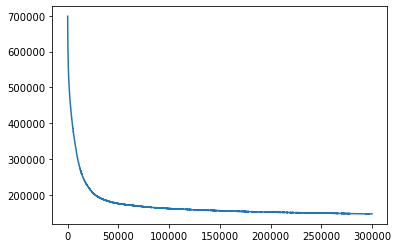

In [46]:
start = 50
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

In [47]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
means = model.get_means(predict_timepoints)

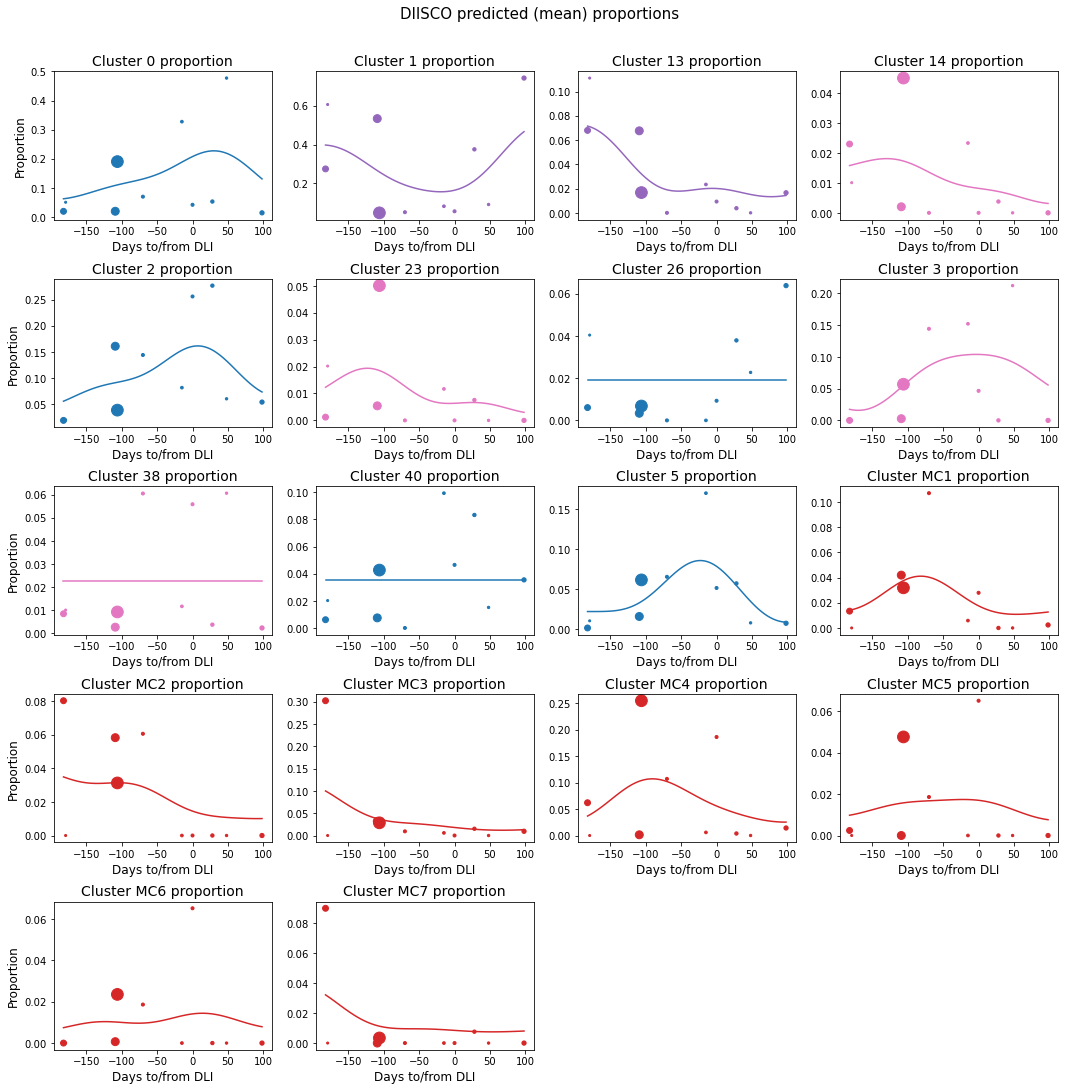

In [48]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    mean = unscale(means['Y'][:, i], i)
    x = predict_timepoints.squeeze().numpy()
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted (mean) proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)

In [49]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                 n_samples=10000, 
                 n_samples_per_latent=10,
                 include_emission_variance=False)

100%|██████████████████████████████████████████████| 10000/10000 [04:54<00:00, 34.00it/s]


In [50]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

In [51]:
y_preds = y_samples_predict.mean(axis=0).numpy()

np.save('../../data/AML/run_1_X_NR.npy', predict_timepoints.numpy())
np.save('../../data/AML/run_1_y_preds_NR.npy', y_preds)
np.save('../../data/AML/run_1_W_samples_predict_NR.npy', W_samples_predict)
np.save('../../data/AML/run_1_y_samples_predict_NR.npy', y_samples_predict)

In [66]:
predict_timepoints = np.load('../../data/AML/run_1_X_NR.npy')
y_preds = np.load('../../data/AML/run_1_y_preds_NR.npy')
W_samples_predict = np.load('../../data/AML/run_1_W_samples_predict_NR.npy')
y_samples_predict = np.load('../../data/AML/run_1_y_samples_predict_NR.npy')

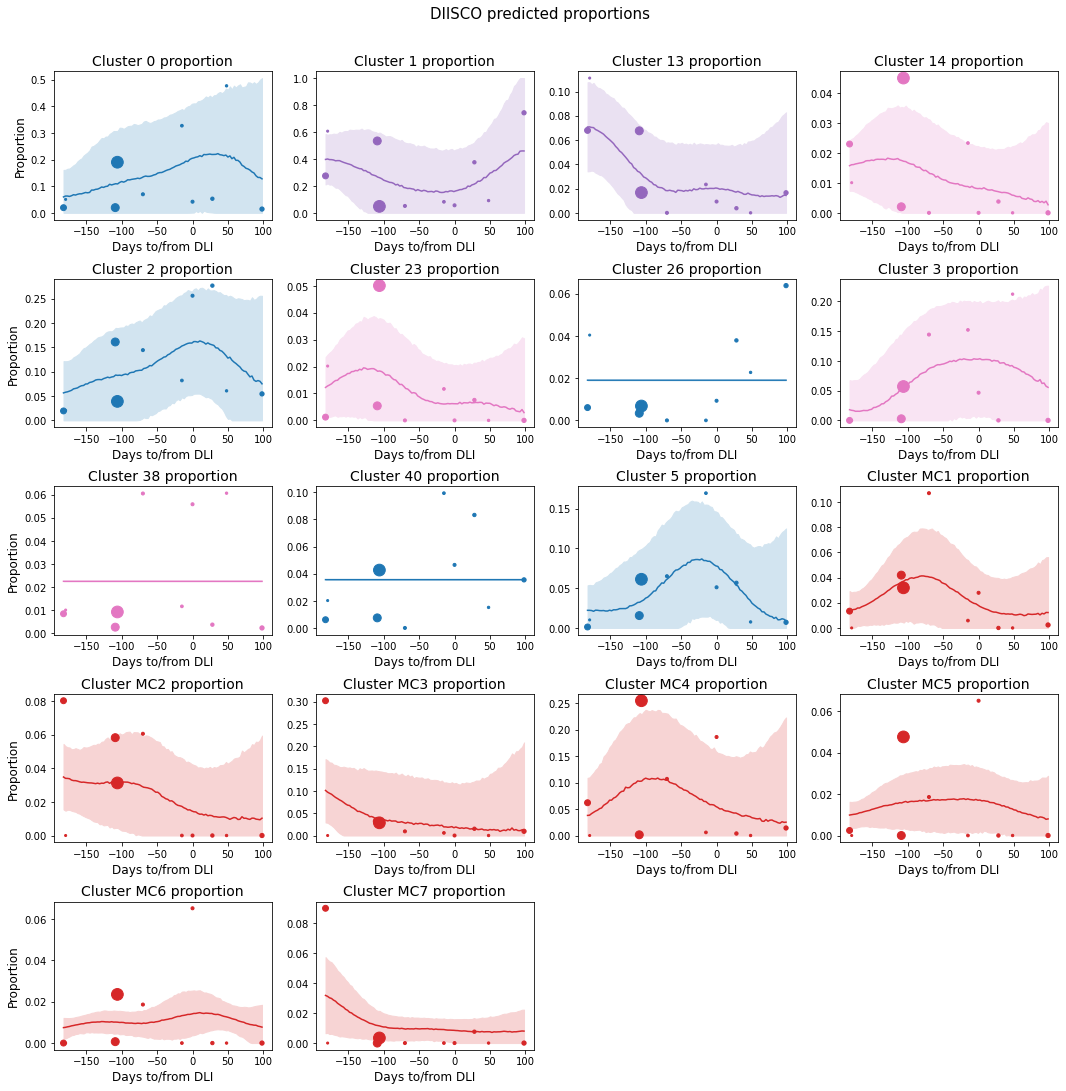

In [67]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    color_with_alpha = list(colors2.to_rgb(color)) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    plt.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)
plt.savefig('../../figures/AML/run_1/diisco_predictions_NR.eps')

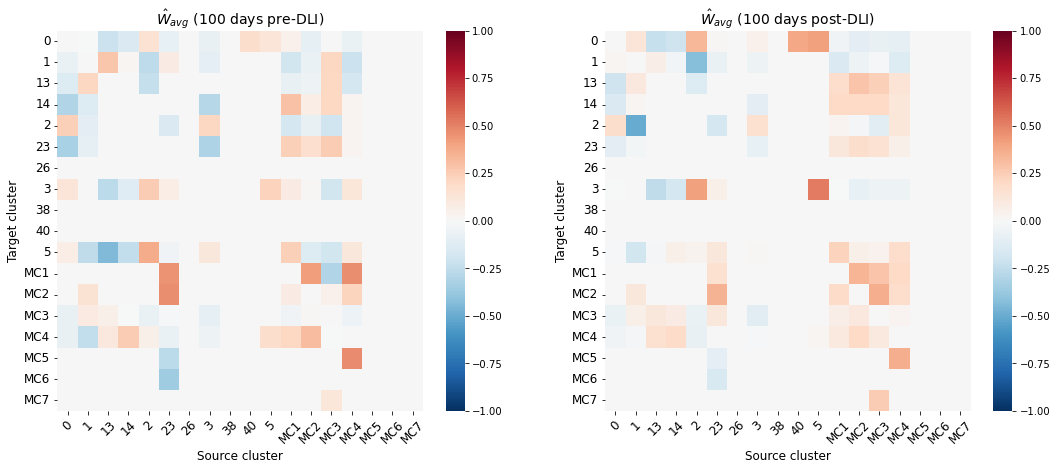

In [68]:
annot = False
vmin = -1
vmax = 1

X_100_days_pre_dli_index = np.where(predict_timepoints > -100)[0][0]
X_post_dli_index = np.where(predict_timepoints > 0)[0][0]
X_100_days_post_dli_index = np.where(predict_timepoints > 95)[0][0]
X_post_dli_index

W = W_samples_predict.mean(axis=0)
W_pre_dli = W[X_100_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_100_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (100 days pre-DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (100 days post-DLI)', fontsize=14)
plt.savefig('../../figures/AML/run_1/W_avg_pre_post_DLI_NR.eps')

In [69]:
y_mu = y_samples_predict.mean(axis=0).mean(axis=0)
y_mu = [unscale(y_mu[i], i) for i in range(len(y_mu))]

y_sigma = y_samples_predict.std(axis=0).mean(axis=0)
y_sigma = [unscale(y_sigma[i], i) for i in range(len(y_sigma))]

y_mu_over_sigma = np.array(y_mu) / np.array(y_sigma)

Text(0, 0.5, 'y_mu / y_sigma')

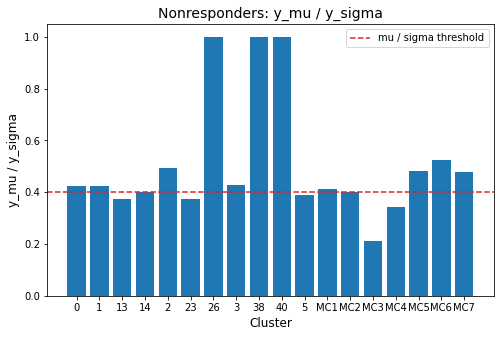

In [70]:
plt.figure(figsize=(8, 5))
mu_sigma_threshold = 0.4
plt.bar(range(len(y_mu_over_sigma)), y_mu_over_sigma)
plt.xticks(range(len(y_mu_over_sigma)), clusters_of_interest)
plt.axhline(mu_sigma_threshold, c='tab:red', linestyle='--', label='mu / sigma threshold')
plt.legend(loc='upper right')
plt.title("Nonresponders: y_mu / y_sigma", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("y_mu / y_sigma", fontsize=12)

In [71]:
mean_abs_W_threshold = 0.25
max_abs_W_threshold = 1
mu_sigma_threshold = 0.4

Text(0.5, 0, 'Days to/from DLI')

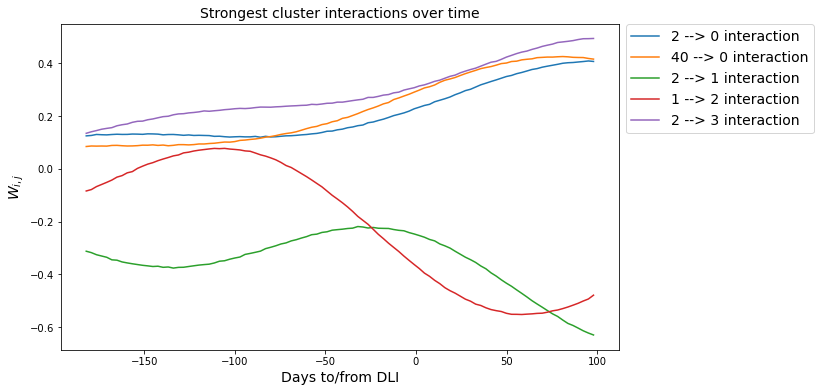

In [72]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(),
                     W[:, i, j],
                     linestyle=linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


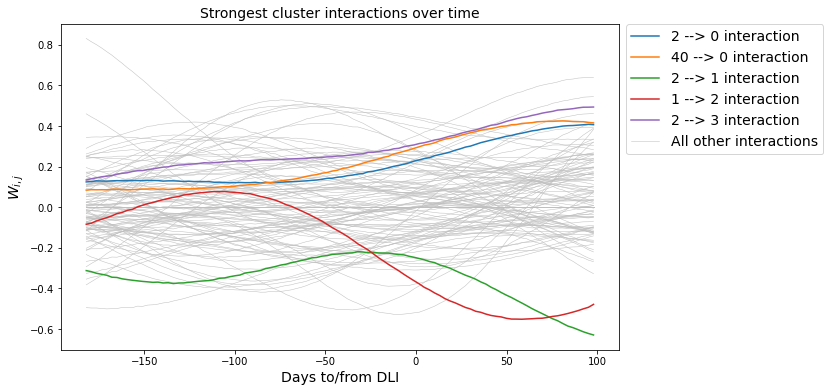

In [73]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_1/W_over_time_NR_all_interactions.eps', bbox_inches='tight')

In [74]:
import py4cytoscape as p4c
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

In [75]:
W_pre_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_pre_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_pre_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_pre_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_pre_dli_avg_over_time[row, col])
        })

W_pre_dli_avg_edge_list_df = pd.DataFrame(W_pre_dli_avg_edge_list)

W_avg_edge_list_df = W_pre_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,1,0,-0.006707,0.000000,-1.0
2,13,0,-0.212920,0.000000,-1.0
3,14,0,-0.152949,0.000000,-1.0
4,2,0,0.151562,0.151562,1.0
5,23,0,-0.079457,0.000000,-1.0


In [76]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_pre_dli = y_preds[X_100_days_pre_dli_index:X_post_dli_index]
y_preds_avg_pre_dli = y_preds_pre_dli.mean(axis=0)
y_preds_avg_pre_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_pre_dli)]
y_preds_avg_pre_dli_df = pd.DataFrame(y_preds_avg_pre_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_pre_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

,id,Inferred cluster proportion
0,0,0.152055
1,1,0.180142
2,13,0.020279
3,14,0.011774
4,2,0.123004
5,23,0.010112
6,26,0.019040
7,3,0.090484
8,38,0.022531
9,40,0.035626


In [77]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.01, 'id']
clusters_with_low_prop = []

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [78]:
# Add clusters from R interaction network diagram
clusters_to_add = {
    '20': 'B cell',
    '5': 'T cell',
    'MC4': 'Myeloid', 
    'MC2': 'Myeloid'
}

proportions_pre_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] < 0]
proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
proportions_pre_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_pre_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/282936603.py:10: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/282936603.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/282936603.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/282936603.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

In [79]:
colors_hex = {
    'T cell': '#CBE0EE',
    'B cell': '#F9E0F2',
    'Myeloid': '#F8CECD',
    'AML': '#E1E1E1',
    'HSC': '#F8EBCB',
    'NK cell': '#E7DDF0'
}

clusters_to_colors_hex = [
    colors_hex[clusters_of_interest[cluster]] if cluster in clusters_of_interest
    else colors_hex[clusters_to_add[cluster]]
    for cluster in y_preds_avg_df['id']
]

# clusters_to_colors_hex = ['#CBE0EE' for cluster in y_preds_avg_df['id']]

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


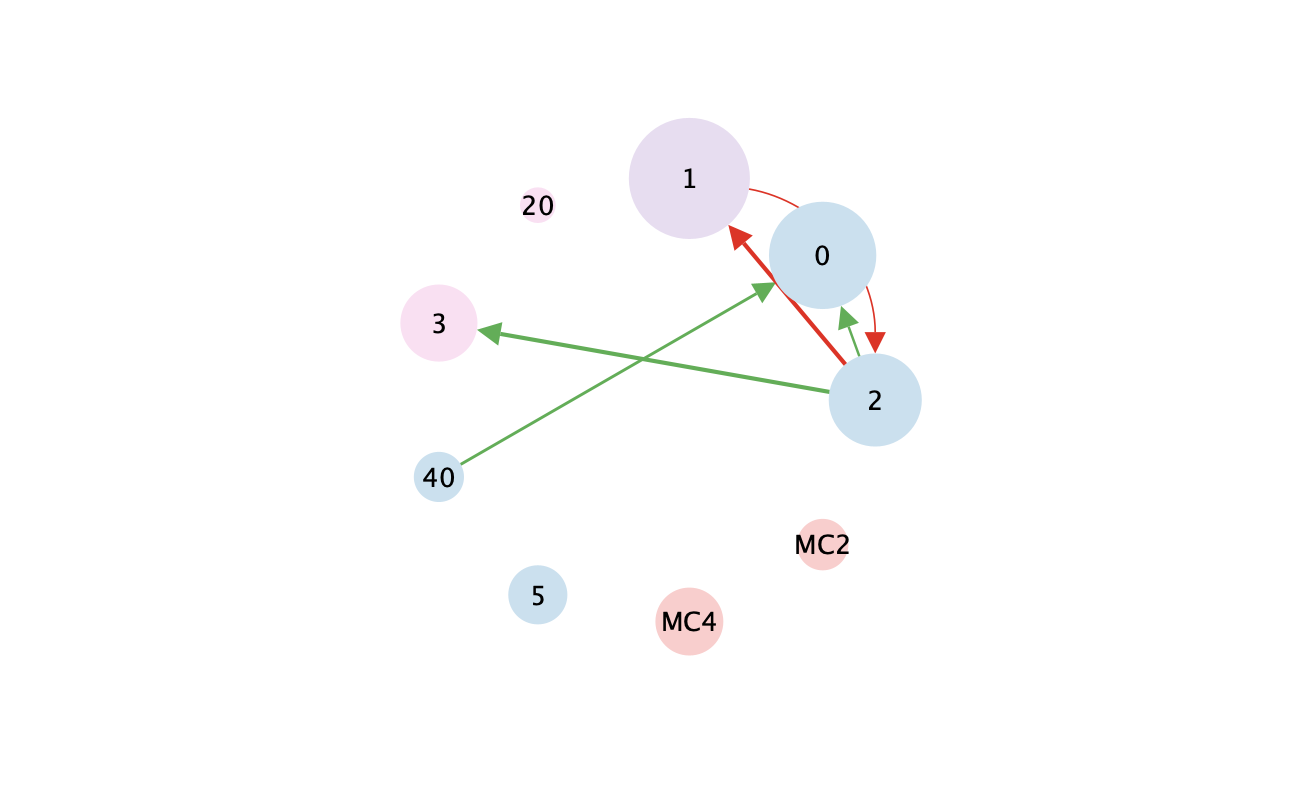

In [81]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Non-responders Pre DLI", 
                                    collection="AML Non-responders Pre DLI")

# Default styles
p4c.layout_network('circular')
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Non-responders Pre DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 150 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(2)
p4c.export_image(f'../../figures/AML/run_1/interaction_network_NR_pre_avg.svg', type='SVG')
p4c.export_image(f'../../figures/AML/run_1/interaction_network_NR_pre_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [82]:
W_post_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_post_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_post_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_post_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_post_dli_avg_over_time[row, col])
        })
        
W_post_dli_avg_edge_list_df = pd.DataFrame(W_post_dli_avg_edge_list)

W_avg_edge_list_df = W_post_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,1,0,0.130418,0.000000,1.0
2,13,0,-0.231085,0.000000,-1.0
3,14,0,-0.210655,0.000000,-1.0
4,2,0,0.333978,0.333978,1.0
5,23,0,0.014416,0.000000,1.0


In [83]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_post_dli = y_preds[X_post_dli_index:X_100_days_post_dli_index]
y_preds_avg_post_dli = y_preds_post_dli.mean(axis=0)
y_preds_avg_post_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_post_dli)]
y_preds_avg_post_dli_df = pd.DataFrame(y_preds_avg_post_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_post_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

,id,Inferred cluster proportion
0,0,0.197681
1,1,0.288532
2,13,0.015895
3,14,0.005961
4,2,0.129330
5,23,0.005650
6,26,0.019040
7,3,0.087427
8,38,0.022531
9,40,0.035626


In [84]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.01, 'id']
clusters_with_low_prop = []

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [85]:
# Add clusters from R interaction network diagram
clusters_to_add = {
    '20': 'B cell',
    '5': 'T cell',
    'MC4': 'Myeloid', 
    'MC2': 'Myeloid'
}

proportions_post_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] >= 0]
proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
proportions_post_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_post_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/3275758011.py:10: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/3275758011.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/3275758011.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_14904/3275758011.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


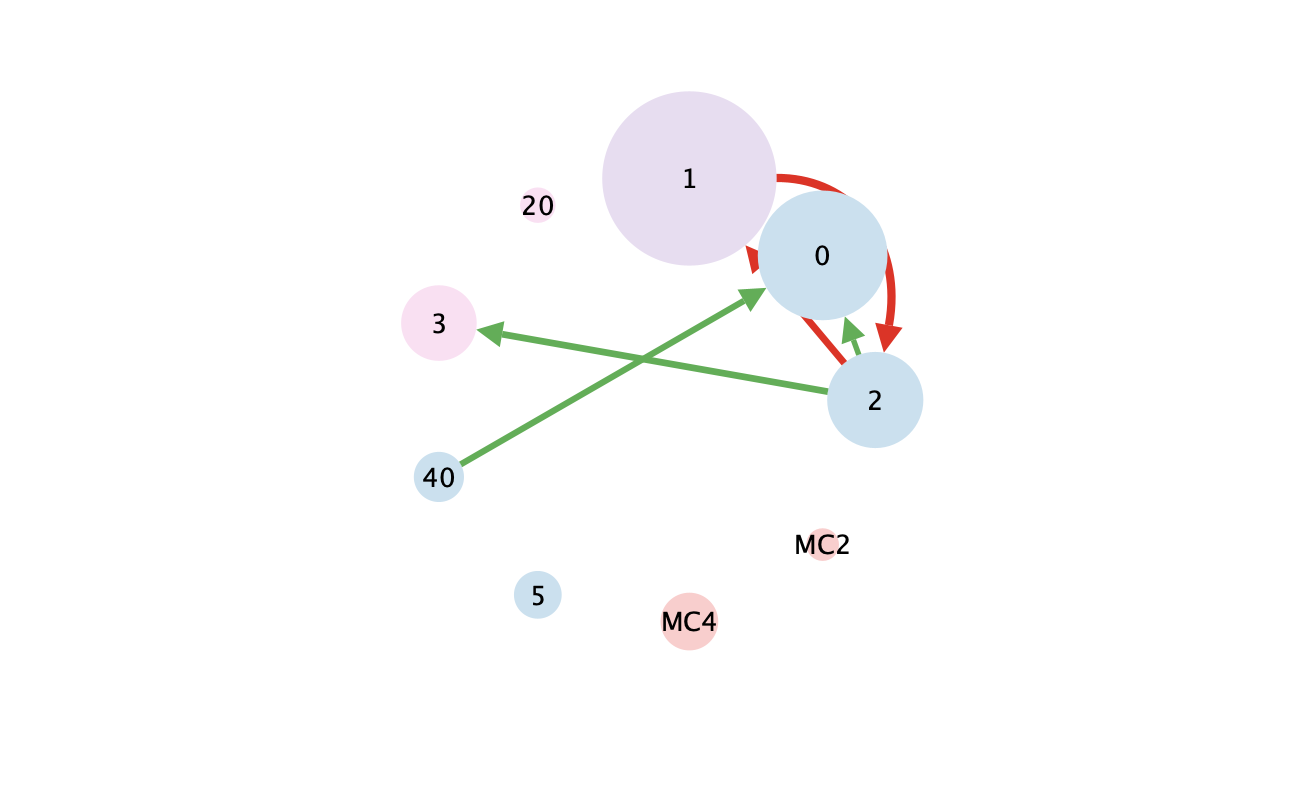

In [86]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Non-responders Post DLI", 
                                    collection="AML Non-responders Post DLI")

# Default styles
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Non-responders Post DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 150 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(2)
p4c.export_image(f'../../figures/AML/run_1/interaction_network_NR_post_avg.svg', type='SVG')
p4c.export_image(f'../../figures/AML/run_1/interaction_network_NR_post_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [87]:
# interactions_over_time_summary = []

# for i, cluster_i in enumerate(clusters_of_interest):
#     for j, cluster_j in enumerate(clusters_of_interest):
#         # a sustained strong interaction over the entire post-DLI time period
#         sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
#         # a transient strong interaction during the post-DLI time period
#         transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
#         interactions_over_time_summary.append({
#             'Source': cluster_j,
#             'Target': cluster_i,
#             'W_abs_val_post_dli_max': np.max(np.abs(W_post_dli[:, i, j])),
#             f'Transient (W_abs_val_post_dli_max > {max_abs_W_threshold})': transient,
#             'W_abs_val_post_dli_avg': np.abs(W_post_dli_avg_over_time[i, j]),
#             f'Sustained (W_abs_val_post_dli_avg > {mean_abs_W_threshold})': sustained,
#             'Transient OR Sustained': transient or sustained
#         })

# interactions_over_time_summary_df = pd.DataFrame(interactions_over_time_summary)
# interactions_over_time_summary_df = interactions_over_time_summary_df.\
#                                         sort_values(['Transient OR Sustained', 
#                                                      'W_abs_val_post_dli_max'], 
#                                                     ascending=False)

# interactions_over_time_summary_df.to_csv('../../data/AML/AML_R_interactions_over_time_summary.csv', 
#                                          index=False)
# interactions_over_time_summary_df.head()